In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

/data/home/achmad.kurnianto/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 35


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(838446, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,352902031A3#23,352902031A3,352902031,1,2022_03,2,V2,49MHN,-14.442355,-14.630594,...,-15.103313,-14.772108,-13.547131,-15.910433,-14.354086,3529,8,0.306146,R19C14,0.061788
1,352902032A2#09,352902032A2,352902032,1,2022_03,2,V2,49MHN,-14.780339,-14.659796,...,-15.058085,-14.376867,-14.307077,-13.904964,-13.743226,3529,8,0.241498,R19C14,0.061788
2,352902032B3#23,352902032B3,352902032,1,2022_03,2,V2,49MHN,-14.889246,-14.054317,...,-16.695141,-15.863261,-15.827219,-15.949875,-15.095640,3529,8,0.236998,R19C14,0.061788
3,352903002A1#10,352903002A1,352903002,1,2022_03,2,V2,49MHN,-21.030432,-18.848495,...,-20.426426,-19.460685,-19.205427,-19.538044,-19.017312,3529,8,0.193751,R11C15,0.218776
4,352903002B1#10,352903002B1,352903002,1,2022_03,2,V2,49MHN,-23.875937,-23.916334,...,-20.064854,-19.911311,-22.819595,-17.958206,-19.311778,3529,8,0.900768,R10C17,0.091853


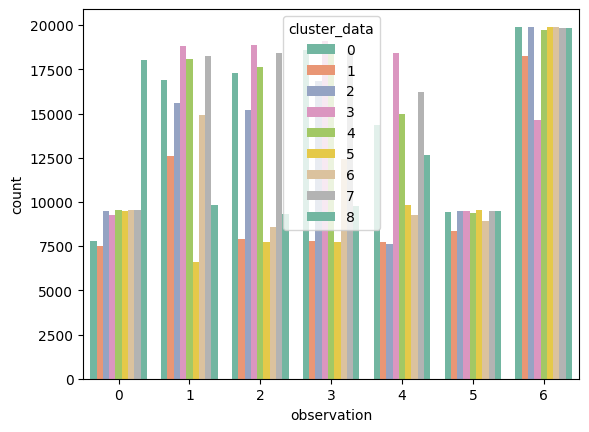

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-24 09:34:10,213] A new study created in memory with name: no-name-e2bd8382-5822-4a25-b6bc-66bb0292efa4


[3 2 6 1 4 0 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 09:34:45,951] Trial 0 finished with value: 0.8338590671315843 and parameters: {'max_depth': 7, 'learning_rate': 0.05653271402934078, 'reg_lambda': 3.468467879379797, 'min_child_weight': 92}. Best is trial 0 with value: 0.8338590671315843.


[I 2024-10-24 09:35:17,327] Trial 1 finished with value: 0.832563846031947 and parameters: {'max_depth': 6, 'learning_rate': 0.07177806992812899, 'reg_lambda': 2.902206033090663, 'min_child_weight': 97}. Best is trial 0 with value: 0.8338590671315843.


[I 2024-10-24 09:35:50,566] Trial 2 finished with value: 0.8343759475136673 and parameters: {'max_depth': 6, 'learning_rate': 0.0655343372644554, 'reg_lambda': 3.5874839249314854, 'min_child_weight': 96}. Best is trial 2 with value: 0.8343759475136673.


[I 2024-10-24 09:37:06,481] Trial 3 finished with value: 0.8368623395503878 and parameters: {'max_depth': 10, 'learning_rate': 0.03853136270511873, 'reg_lambda': 0.582088165608649, 'min_child_weight': 76}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:39:34,682] Trial 4 finished with value: 0.8346209590664504 and parameters: {'max_depth': 9, 'learning_rate': 0.018248398467847114, 'reg_lambda': 1.188820302111872, 'min_child_weight': 89}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:41:17,680] Trial 5 finished with value: 0.8331400454754831 and parameters: {'max_depth': 6, 'learning_rate': 0.035638312079805536, 'reg_lambda': 0.6414997471702518, 'min_child_weight': 95}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:42:30,581] Trial 6 finished with value: 0.8367960657883593 and parameters: {'max_depth': 9, 'learning_rate': 0.05184272177903452, 'reg_lambda': 4.259548000877224, 'min_child_weight': 97}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:44:30,350] Trial 7 finished with value: 0.8320473004084409 and parameters: {'max_depth': 7, 'learning_rate': 0.020898906151605664, 'reg_lambda': 2.0786831476118124, 'min_child_weight': 90}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:45:10,151] Trial 8 finished with value: 0.8332920831028422 and parameters: {'max_depth': 9, 'learning_rate': 0.09737750353626524, 'reg_lambda': 0.7036566243043856, 'min_child_weight': 88}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:46:15,254] Trial 9 finished with value: 0.8347253998974496 and parameters: {'max_depth': 8, 'learning_rate': 0.055120157713768936, 'reg_lambda': 0.3255440135944404, 'min_child_weight': 83}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:47:50,927] Trial 10 finished with value: 0.8367235478147886 and parameters: {'max_depth': 10, 'learning_rate': 0.03576430556431105, 'reg_lambda': 1.7277553592433674, 'min_child_weight': 62}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:49:19,719] Trial 11 finished with value: 0.8360551593241751 and parameters: {'max_depth': 10, 'learning_rate': 0.038560072499980245, 'reg_lambda': 4.750065985108154, 'min_child_weight': 71}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:50:04,744] Trial 12 finished with value: 0.8364920575313003 and parameters: {'max_depth': 9, 'learning_rate': 0.0831434010854111, 'reg_lambda': 4.627322649866044, 'min_child_weight': 75}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:51:16,262] Trial 13 finished with value: 0.8363151505710297 and parameters: {'max_depth': 10, 'learning_rate': 0.04482511871956621, 'reg_lambda': 4.093546698877548, 'min_child_weight': 50}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:52:28,865] Trial 14 finished with value: 0.8361841533298316 and parameters: {'max_depth': 9, 'learning_rate': 0.04812062041744646, 'reg_lambda': 2.6446449031469093, 'min_child_weight': 66}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:54:23,229] Trial 15 finished with value: 0.8340891508945595 and parameters: {'max_depth': 8, 'learning_rate': 0.028271306516869876, 'reg_lambda': 1.5611289004673852, 'min_child_weight': 81}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:55:16,466] Trial 16 finished with value: 0.8366940664092103 and parameters: {'max_depth': 10, 'learning_rate': 0.06588491650957214, 'reg_lambda': 3.2012903152128662, 'min_child_weight': 57}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:56:07,157] Trial 17 finished with value: 0.836005728218484 and parameters: {'max_depth': 9, 'learning_rate': 0.07738330557367872, 'reg_lambda': 2.2169771625320953, 'min_child_weight': 100}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:57:19,283] Trial 18 finished with value: 0.833136639385387 and parameters: {'max_depth': 8, 'learning_rate': 0.04871079941276971, 'reg_lambda': 4.0304033582038326, 'min_child_weight': 82}. Best is trial 3 with value: 0.8368623395503878.


[I 2024-10-24 09:58:42,008] Trial 19 finished with value: 0.8364407854334585 and parameters: {'max_depth': 10, 'learning_rate': 0.026474465282529266, 'reg_lambda': 0.15858019626544095, 'min_child_weight': 76}. Best is trial 3 with value: 0.8368623395503878.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.03853136270511873, 'reg_lambda': 0.582088165608649, 'min_child_weight': 76}
Best Score: 0.8368623395503878
Start the modelling
[0]	train-mlogloss:1.86304	eval-mlogloss:1.86636


[100]	train-mlogloss:0.30312	eval-mlogloss:0.49059


[200]	train-mlogloss:0.16473	eval-mlogloss:0.40473


[300]	train-mlogloss:0.11348	eval-mlogloss:0.38334


[400]	train-mlogloss:0.08296	eval-mlogloss:0.37684


[500]	train-mlogloss:0.06373	eval-mlogloss:0.37551


[600]	train-mlogloss:0.05155	eval-mlogloss:0.37597


[700]	train-mlogloss:0.04264	eval-mlogloss:0.37809


[800]	train-mlogloss:0.03688	eval-mlogloss:0.38035


[900]	train-mlogloss:0.03228	eval-mlogloss:0.38346


[1000]	train-mlogloss:0.02862	eval-mlogloss:0.38671


[1100]	train-mlogloss:0.02564	eval-mlogloss:0.39013


[1200]	train-mlogloss:0.02331	eval-mlogloss:0.39309


[1300]	train-mlogloss:0.02129	eval-mlogloss:0.39596


[1400]	train-mlogloss:0.01963	eval-mlogloss:0.39849


[1493]	train-mlogloss:0.01834	eval-mlogloss:0.40095


[0]	train-mlogloss:1.86369	eval-mlogloss:1.86714


[100]	train-mlogloss:0.30858	eval-mlogloss:0.49441


[200]	train-mlogloss:0.16567	eval-mlogloss:0.40954


[300]	train-mlogloss:0.11273	eval-mlogloss:0.38817


[400]	train-mlogloss:0.08362	eval-mlogloss:0.38081


[500]	train-mlogloss:0.06407	eval-mlogloss:0.37852


[600]	train-mlogloss:0.05183	eval-mlogloss:0.37880


[700]	train-mlogloss:0.04297	eval-mlogloss:0.37993


[800]	train-mlogloss:0.03694	eval-mlogloss:0.38196


[900]	train-mlogloss:0.03237	eval-mlogloss:0.38440


[1000]	train-mlogloss:0.02866	eval-mlogloss:0.38729


[1100]	train-mlogloss:0.02573	eval-mlogloss:0.39023


[1200]	train-mlogloss:0.02333	eval-mlogloss:0.39297


[1300]	train-mlogloss:0.02141	eval-mlogloss:0.39561


[1400]	train-mlogloss:0.01968	eval-mlogloss:0.39793


[1497]	train-mlogloss:0.01827	eval-mlogloss:0.40030


[0]	train-mlogloss:1.86318	eval-mlogloss:1.86637


[100]	train-mlogloss:0.30209	eval-mlogloss:0.48829


[200]	train-mlogloss:0.16166	eval-mlogloss:0.40151


[300]	train-mlogloss:0.10992	eval-mlogloss:0.38026


[400]	train-mlogloss:0.08079	eval-mlogloss:0.37383


[500]	train-mlogloss:0.06176	eval-mlogloss:0.37241


[600]	train-mlogloss:0.05034	eval-mlogloss:0.37362


[700]	train-mlogloss:0.04209	eval-mlogloss:0.37570


[800]	train-mlogloss:0.03591	eval-mlogloss:0.37802


[900]	train-mlogloss:0.03161	eval-mlogloss:0.38088


[1000]	train-mlogloss:0.02814	eval-mlogloss:0.38410


[1100]	train-mlogloss:0.02543	eval-mlogloss:0.38755


[1200]	train-mlogloss:0.02321	eval-mlogloss:0.39029


[1300]	train-mlogloss:0.02119	eval-mlogloss:0.39353


[1400]	train-mlogloss:0.01946	eval-mlogloss:0.39667


[1493]	train-mlogloss:0.01811	eval-mlogloss:0.39919


[0]	train-mlogloss:1.86168	eval-mlogloss:1.86468


[50]	train-mlogloss:0.56809	eval-mlogloss:0.66921


[100]	train-mlogloss:0.31774	eval-mlogloss:0.47334


[150]	train-mlogloss:0.22849	eval-mlogloss:0.41477


[200]	train-mlogloss:0.18277	eval-mlogloss:0.38951


[250]	train-mlogloss:0.15198	eval-mlogloss:0.37560


[300]	train-mlogloss:0.12927	eval-mlogloss:0.36712


[350]	train-mlogloss:0.11208	eval-mlogloss:0.36161


[400]	train-mlogloss:0.09752	eval-mlogloss:0.35804


[450]	train-mlogloss:0.08551	eval-mlogloss:0.35564


[500]	train-mlogloss:0.07549	eval-mlogloss:0.35407


[550]	train-mlogloss:0.06821	eval-mlogloss:0.35325


[600]	train-mlogloss:0.06153	eval-mlogloss:0.35296


[650]	train-mlogloss:0.05626	eval-mlogloss:0.35301


[667]	train-mlogloss:0.05454	eval-mlogloss:0.35308



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      5466
           1       0.92      0.94      0.93     11819
           2       0.96      0.96      0.96     12092
           3       0.95      0.95      0.95     12996
           4       0.94      0.97      0.96     10051
           5       0.64      0.57      0.61      6604
           6       0.78      0.86      0.82     13907

    accuracy                           0.88     72935
   macro avg       0.85      0.84      0.84     72935
weighted avg       0.87      0.88      0.87     72935



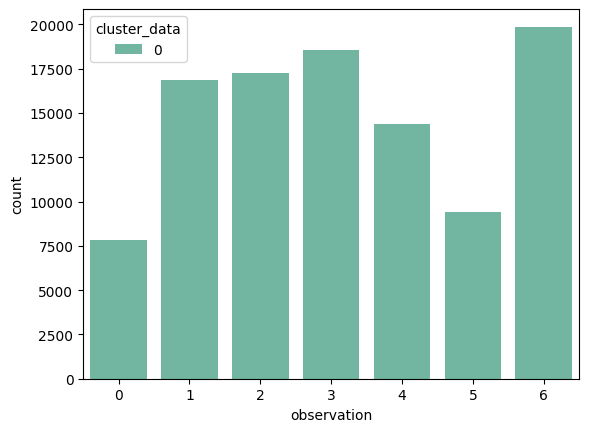

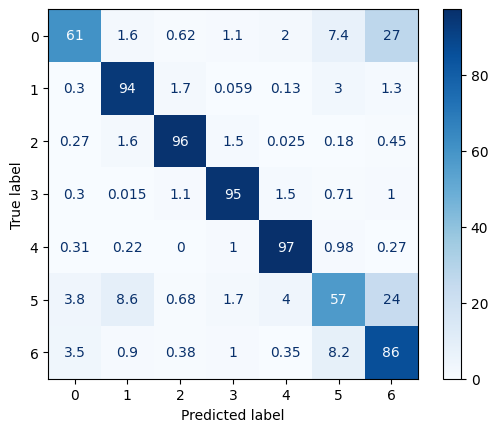

{'average_accuracy': 0.8720286655789103, 'average_f1_macro': np.float64(0.8388586941479651), 'average_f1_micro': np.float64(0.8720286655789103), 'average_auc': np.float64(0.9755651266377212), 'average_acc_kelas_generatif': 0.9508074449581887, 'average_acc_fase_padi': 0.9520000960507812}
{'val_accuracy': 0.8751902378830465, 'val_f1_macro': np.float64(0.8431473385751501), 'val_f1_micro': np.float64(0.8751902378830465), 'val_auc': np.float64(0.9781983433655312), 'val_acc_kelas_generatif': 0.953601108033241, 'val_acc_fase_padi': 0.9545551343753993, 'val_relative_acc': np.float64(99.37337732055362)}
CLUSTER:  1


[I 2024-10-24 10:01:04,213] A new study created in memory with name: no-name-64263ec7-5030-4122-b0bf-0a1cae1f2ee2


[1 5 2 6 4 0 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 10:01:25,285] Trial 0 finished with value: 0.8585242085357243 and parameters: {'max_depth': 8, 'learning_rate': 0.0855860303051371, 'reg_lambda': 3.219079357724614, 'min_child_weight': 92}. Best is trial 0 with value: 0.8585242085357243.


[I 2024-10-24 10:02:14,609] Trial 1 finished with value: 0.8628416504044919 and parameters: {'max_depth': 9, 'learning_rate': 0.03259961676095419, 'reg_lambda': 3.178960674883321, 'min_child_weight': 79}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:02:46,215] Trial 2 finished with value: 0.859109386867145 and parameters: {'max_depth': 7, 'learning_rate': 0.053437673694629484, 'reg_lambda': 0.10592197544002213, 'min_child_weight': 85}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:03:14,622] Trial 3 finished with value: 0.8610113963115574 and parameters: {'max_depth': 9, 'learning_rate': 0.05428873679014163, 'reg_lambda': 1.1992261673723752, 'min_child_weight': 62}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:03:33,731] Trial 4 finished with value: 0.8606980232027978 and parameters: {'max_depth': 9, 'learning_rate': 0.08964216637038448, 'reg_lambda': 4.02259316391885, 'min_child_weight': 57}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:03:57,234] Trial 5 finished with value: 0.8612654294460468 and parameters: {'max_depth': 9, 'learning_rate': 0.070444700236523, 'reg_lambda': 0.5610356078518783, 'min_child_weight': 82}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:04:51,714] Trial 6 finished with value: 0.8608969377284433 and parameters: {'max_depth': 9, 'learning_rate': 0.028241027622423358, 'reg_lambda': 2.898353979021086, 'min_child_weight': 95}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:05:17,731] Trial 7 finished with value: 0.8607371973022042 and parameters: {'max_depth': 7, 'learning_rate': 0.0641478893031321, 'reg_lambda': 4.799865764071242, 'min_child_weight': 90}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:05:38,266] Trial 8 finished with value: 0.858945368941693 and parameters: {'max_depth': 7, 'learning_rate': 0.07378834481231616, 'reg_lambda': 3.0197309123113194, 'min_child_weight': 73}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:06:02,470] Trial 9 finished with value: 0.8624278876780158 and parameters: {'max_depth': 8, 'learning_rate': 0.0700406574787348, 'reg_lambda': 3.966059137621951, 'min_child_weight': 85}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:07:27,652] Trial 10 finished with value: 0.858191343087781 and parameters: {'max_depth': 10, 'learning_rate': 0.010143093124979019, 'reg_lambda': 1.5888485206376117, 'min_child_weight': 70}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:08:11,437] Trial 11 finished with value: 0.8602150907463902 and parameters: {'max_depth': 8, 'learning_rate': 0.036181549092817684, 'reg_lambda': 4.043265246345655, 'min_child_weight': 80}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:08:58,944] Trial 12 finished with value: 0.8584588735248492 and parameters: {'max_depth': 6, 'learning_rate': 0.033833161841753716, 'reg_lambda': 2.121996619184574, 'min_child_weight': 100}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:09:36,650] Trial 13 finished with value: 0.861232771363535 and parameters: {'max_depth': 10, 'learning_rate': 0.04131803360531022, 'reg_lambda': 3.980285043525816, 'min_child_weight': 69}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:09:54,026] Trial 14 finished with value: 0.8620620722461076 and parameters: {'max_depth': 8, 'learning_rate': 0.09974351226893471, 'reg_lambda': 4.97124974421268, 'min_child_weight': 78}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:11:03,941] Trial 15 finished with value: 0.8580856207065845 and parameters: {'max_depth': 8, 'learning_rate': 0.01594014174975772, 'reg_lambda': 3.3680269547107664, 'min_child_weight': 50}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:11:41,462] Trial 16 finished with value: 0.8615629354749844 and parameters: {'max_depth': 10, 'learning_rate': 0.04488412205760959, 'reg_lambda': 2.3511047905483364, 'min_child_weight': 86}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:12:31,003] Trial 17 finished with value: 0.8570606384529863 and parameters: {'max_depth': 6, 'learning_rate': 0.024635592174777832, 'reg_lambda': 3.7070192953800585, 'min_child_weight': 65}. Best is trial 1 with value: 0.8628416504044919.


[I 2024-10-24 10:12:56,866] Trial 18 finished with value: 0.86377884562286 and parameters: {'max_depth': 9, 'learning_rate': 0.06317536540422969, 'reg_lambda': 4.464586481218989, 'min_child_weight': 76}. Best is trial 18 with value: 0.86377884562286.


[I 2024-10-24 10:13:29,052] Trial 19 finished with value: 0.8625613647345745 and parameters: {'max_depth': 9, 'learning_rate': 0.05026446025346638, 'reg_lambda': 4.5622258764990855, 'min_child_weight': 75}. Best is trial 18 with value: 0.86377884562286.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.06317536540422969, 'reg_lambda': 4.464586481218989, 'min_child_weight': 76}
Best Score: 0.86377884562286
Start the modelling
[0]	train-mlogloss:1.81308	eval-mlogloss:1.82286


[100]	train-mlogloss:0.18317	eval-mlogloss:0.43092


[200]	train-mlogloss:0.09488	eval-mlogloss:0.39389


[300]	train-mlogloss:0.06060	eval-mlogloss:0.38741


[400]	train-mlogloss:0.04364	eval-mlogloss:0.38829


[500]	train-mlogloss:0.03404	eval-mlogloss:0.39148


[600]	train-mlogloss:0.02796	eval-mlogloss:0.39463


[700]	train-mlogloss:0.02374	eval-mlogloss:0.39830


[800]	train-mlogloss:0.02077	eval-mlogloss:0.40211


[900]	train-mlogloss:0.01857	eval-mlogloss:0.40512


[1000]	train-mlogloss:0.01694	eval-mlogloss:0.40807


[1100]	train-mlogloss:0.01562	eval-mlogloss:0.41080


[1200]	train-mlogloss:0.01457	eval-mlogloss:0.41366


[1300]	train-mlogloss:0.01366	eval-mlogloss:0.41632


[1310]	train-mlogloss:0.01358	eval-mlogloss:0.41663


[0]	train-mlogloss:1.81198	eval-mlogloss:1.82086


[100]	train-mlogloss:0.18468	eval-mlogloss:0.42779


[200]	train-mlogloss:0.09355	eval-mlogloss:0.38529


[300]	train-mlogloss:0.05991	eval-mlogloss:0.37830


[400]	train-mlogloss:0.04271	eval-mlogloss:0.37884


[500]	train-mlogloss:0.03376	eval-mlogloss:0.38227


[600]	train-mlogloss:0.02774	eval-mlogloss:0.38694


[700]	train-mlogloss:0.02365	eval-mlogloss:0.39060


[800]	train-mlogloss:0.02077	eval-mlogloss:0.39399


[900]	train-mlogloss:0.01867	eval-mlogloss:0.39741


[1000]	train-mlogloss:0.01706	eval-mlogloss:0.40083


[1100]	train-mlogloss:0.01578	eval-mlogloss:0.40386


[1200]	train-mlogloss:0.01476	eval-mlogloss:0.40682


[1300]	train-mlogloss:0.01389	eval-mlogloss:0.40960


[1326]	train-mlogloss:0.01368	eval-mlogloss:0.41008


[0]	train-mlogloss:1.81119	eval-mlogloss:1.82105


[100]	train-mlogloss:0.18976	eval-mlogloss:0.43409


[200]	train-mlogloss:0.10109	eval-mlogloss:0.39390


[300]	train-mlogloss:0.06575	eval-mlogloss:0.38379


[400]	train-mlogloss:0.04830	eval-mlogloss:0.38263


[500]	train-mlogloss:0.03772	eval-mlogloss:0.38431


[600]	train-mlogloss:0.03060	eval-mlogloss:0.38735


[700]	train-mlogloss:0.02587	eval-mlogloss:0.39110


[800]	train-mlogloss:0.02265	eval-mlogloss:0.39481


[900]	train-mlogloss:0.02018	eval-mlogloss:0.39756


[1000]	train-mlogloss:0.01830	eval-mlogloss:0.40018


[1100]	train-mlogloss:0.01682	eval-mlogloss:0.40279


[1200]	train-mlogloss:0.01562	eval-mlogloss:0.40546


[1300]	train-mlogloss:0.01465	eval-mlogloss:0.40798


[1355]	train-mlogloss:0.01419	eval-mlogloss:0.40908


[0]	train-mlogloss:1.80752	eval-mlogloss:1.81651


[50]	train-mlogloss:0.35826	eval-mlogloss:0.51889


[100]	train-mlogloss:0.19231	eval-mlogloss:0.40372


[150]	train-mlogloss:0.13785	eval-mlogloss:0.37428


[200]	train-mlogloss:0.10639	eval-mlogloss:0.36108


[250]	train-mlogloss:0.08614	eval-mlogloss:0.35421


[300]	train-mlogloss:0.07147	eval-mlogloss:0.35055


[350]	train-mlogloss:0.06010	eval-mlogloss:0.34827


[400]	train-mlogloss:0.05160	eval-mlogloss:0.34748


[450]	train-mlogloss:0.04495	eval-mlogloss:0.34748


[470]	train-mlogloss:0.04261	eval-mlogloss:0.34749



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      5235
           1       0.91      0.95      0.93      8807
           2       0.94      0.96      0.95      5520
           3       0.92      0.87      0.90      5465
           4       0.81      0.80      0.81      5424
           5       0.72      0.68      0.70      5830
           6       0.91      0.92      0.92     12772

    accuracy                           0.88     49053
   macro avg       0.88      0.87      0.87     49053
weighted avg       0.88      0.88      0.88     49053



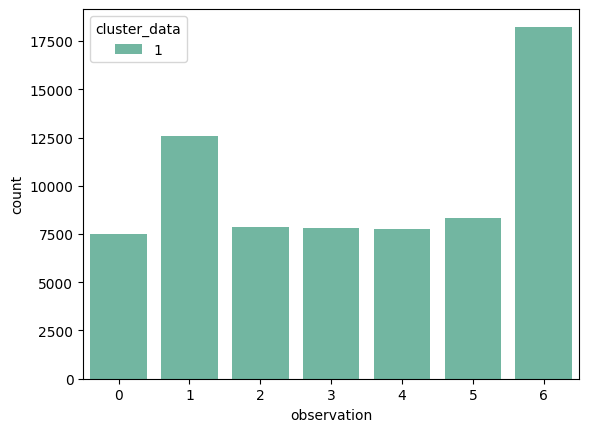

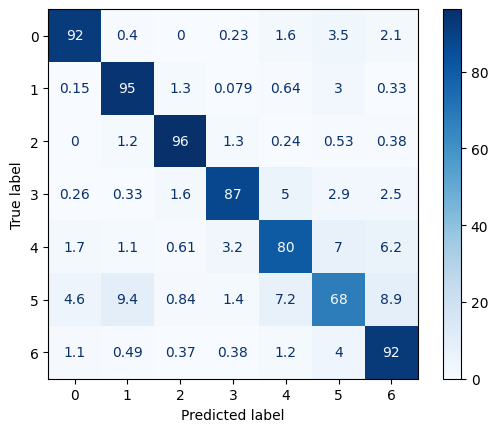

{'average_accuracy': 0.876034570995432, 'average_f1_macro': np.float64(0.8637424653357195), 'average_f1_micro': np.float64(0.876034570995432), 'average_auc': np.float64(0.9810367690901529), 'average_acc_kelas_generatif': 0.86464318154459, 'average_acc_fase_padi': 0.89505830094392}
{'val_accuracy': 0.8836156809981041, 'val_f1_macro': np.float64(0.8734781395552212), 'val_f1_micro': np.float64(0.8836156809981041), 'val_auc': np.float64(0.9840673085032537), 'val_acc_kelas_generatif': 0.8742909423604758, 'val_acc_fase_padi': 0.9031170685279187, 'val_relative_acc': np.float64(98.28797190517999)}
CLUSTER:  2


[I 2024-10-24 10:14:52,885] A new study created in memory with name: no-name-8bbcd9a2-1121-4b45-8621-7d8b9a7addb3


[1 2 6 5 0 4 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 10:15:32,347] Trial 0 finished with value: 0.7573003756103556 and parameters: {'max_depth': 7, 'learning_rate': 0.046848215651883046, 'reg_lambda': 0.9106832995722134, 'min_child_weight': 86}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:15:55,775] Trial 1 finished with value: 0.7572489306038704 and parameters: {'max_depth': 9, 'learning_rate': 0.081880123829967, 'reg_lambda': 1.820269143423792, 'min_child_weight': 88}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:16:19,452] Trial 2 finished with value: 0.7562454760833316 and parameters: {'max_depth': 6, 'learning_rate': 0.07970633867334959, 'reg_lambda': 1.393855412077728, 'min_child_weight': 93}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:16:42,149] Trial 3 finished with value: 0.7563345428557163 and parameters: {'max_depth': 10, 'learning_rate': 0.08433639389882103, 'reg_lambda': 1.1657802116023321, 'min_child_weight': 80}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:17:04,804] Trial 4 finished with value: 0.7572236601548786 and parameters: {'max_depth': 9, 'learning_rate': 0.08567281390393462, 'reg_lambda': 0.6615126821183603, 'min_child_weight': 89}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:18:26,108] Trial 5 finished with value: 0.7543482199335609 and parameters: {'max_depth': 9, 'learning_rate': 0.01476485572204523, 'reg_lambda': 4.972055382563984, 'min_child_weight': 92}. Best is trial 0 with value: 0.7573003756103556.


[I 2024-10-24 10:18:44,930] Trial 6 finished with value: 0.7575681475628478 and parameters: {'max_depth': 6, 'learning_rate': 0.09993822894433502, 'reg_lambda': 2.6368859086909078, 'min_child_weight': 53}. Best is trial 6 with value: 0.7575681475628478.


[I 2024-10-24 10:19:52,758] Trial 7 finished with value: 0.7564730982957436 and parameters: {'max_depth': 7, 'learning_rate': 0.017750129562018806, 'reg_lambda': 2.955254747211814, 'min_child_weight': 59}. Best is trial 6 with value: 0.7575681475628478.


[I 2024-10-24 10:20:12,313] Trial 8 finished with value: 0.755102540328305 and parameters: {'max_depth': 9, 'learning_rate': 0.09924536339735293, 'reg_lambda': 4.145649555171184, 'min_child_weight': 66}. Best is trial 6 with value: 0.7575681475628478.


[I 2024-10-24 10:20:59,779] Trial 9 finished with value: 0.7556150135094599 and parameters: {'max_depth': 6, 'learning_rate': 0.0365867053339058, 'reg_lambda': 2.293421408107066, 'min_child_weight': 91}. Best is trial 6 with value: 0.7575681475628478.


[I 2024-10-24 10:21:26,904] Trial 10 finished with value: 0.7593200637021748 and parameters: {'max_depth': 7, 'learning_rate': 0.06503200679029468, 'reg_lambda': 3.259375509029794, 'min_child_weight': 51}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:21:55,481] Trial 11 finished with value: 0.7577989279083335 and parameters: {'max_depth': 7, 'learning_rate': 0.06471940785871723, 'reg_lambda': 3.2683757227312404, 'min_child_weight': 50}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:22:23,965] Trial 12 finished with value: 0.7575934687388385 and parameters: {'max_depth': 7, 'learning_rate': 0.0626036022760159, 'reg_lambda': 3.542078303754404, 'min_child_weight': 51}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:22:51,986] Trial 13 finished with value: 0.7558465132583311 and parameters: {'max_depth': 8, 'learning_rate': 0.06438861691987657, 'reg_lambda': 3.5838353613145064, 'min_child_weight': 68}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:23:26,249] Trial 14 finished with value: 0.7574497931181589 and parameters: {'max_depth': 8, 'learning_rate': 0.050494417126795345, 'reg_lambda': 3.5222784141678556, 'min_child_weight': 60}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:23:53,677] Trial 15 finished with value: 0.7566804178078576 and parameters: {'max_depth': 7, 'learning_rate': 0.0684510772046307, 'reg_lambda': 4.40900362908849, 'min_child_weight': 71}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:24:35,989] Trial 16 finished with value: 0.7556977029354157 and parameters: {'max_depth': 8, 'learning_rate': 0.03987641778336215, 'reg_lambda': 0.17593160312443779, 'min_child_weight': 100}. Best is trial 10 with value: 0.7593200637021748.


[I 2024-10-24 10:25:01,989] Trial 17 finished with value: 0.7594139994190717 and parameters: {'max_depth': 7, 'learning_rate': 0.07246805547857779, 'reg_lambda': 3.0022104038869157, 'min_child_weight': 57}. Best is trial 17 with value: 0.7594139994190717.


[I 2024-10-24 10:25:27,838] Trial 18 finished with value: 0.7579364841221947 and parameters: {'max_depth': 6, 'learning_rate': 0.07362738480391058, 'reg_lambda': 2.129427907349484, 'min_child_weight': 59}. Best is trial 17 with value: 0.7594139994190717.


[I 2024-10-24 10:26:00,344] Trial 19 finished with value: 0.7561279083361049 and parameters: {'max_depth': 7, 'learning_rate': 0.05575575597269261, 'reg_lambda': 4.055781232598962, 'min_child_weight': 76}. Best is trial 17 with value: 0.7594139994190717.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.07246805547857779, 'reg_lambda': 3.0022104038869157, 'min_child_weight': 57}
Best Score: 0.7594139994190717
Start the modelling
[0]	train-mlogloss:1.81781	eval-mlogloss:1.82428


[100]	train-mlogloss:0.37973	eval-mlogloss:0.60805


[200]	train-mlogloss:0.24957	eval-mlogloss:0.56817


[300]	train-mlogloss:0.17099	eval-mlogloss:0.55945


[400]	train-mlogloss:0.11988	eval-mlogloss:0.55823


[500]	train-mlogloss:0.08898	eval-mlogloss:0.56223


[600]	train-mlogloss:0.06910	eval-mlogloss:0.56886


[700]	train-mlogloss:0.05523	eval-mlogloss:0.57618


[800]	train-mlogloss:0.04450	eval-mlogloss:0.58394


[900]	train-mlogloss:0.03751	eval-mlogloss:0.59099


[1000]	train-mlogloss:0.03207	eval-mlogloss:0.59831


[1100]	train-mlogloss:0.02789	eval-mlogloss:0.60514


[1200]	train-mlogloss:0.02473	eval-mlogloss:0.61159


[1300]	train-mlogloss:0.02215	eval-mlogloss:0.61726


[1382]	train-mlogloss:0.02037	eval-mlogloss:0.62227


[0]	train-mlogloss:1.81778	eval-mlogloss:1.82281


[100]	train-mlogloss:0.37379	eval-mlogloss:0.60572


[200]	train-mlogloss:0.23895	eval-mlogloss:0.56632


[300]	train-mlogloss:0.16357	eval-mlogloss:0.55677


[400]	train-mlogloss:0.11449	eval-mlogloss:0.55835


[500]	train-mlogloss:0.08478	eval-mlogloss:0.56378


[600]	train-mlogloss:0.06552	eval-mlogloss:0.57165


[700]	train-mlogloss:0.05187	eval-mlogloss:0.57991


[800]	train-mlogloss:0.04284	eval-mlogloss:0.58800


[900]	train-mlogloss:0.03608	eval-mlogloss:0.59603


[1000]	train-mlogloss:0.03117	eval-mlogloss:0.60345


[1100]	train-mlogloss:0.02719	eval-mlogloss:0.61069


[1200]	train-mlogloss:0.02415	eval-mlogloss:0.61721


[1300]	train-mlogloss:0.02137	eval-mlogloss:0.62446


[1335]	train-mlogloss:0.02060	eval-mlogloss:0.62669


[0]	train-mlogloss:1.81755	eval-mlogloss:1.82524


[100]	train-mlogloss:0.37069	eval-mlogloss:0.61499


[200]	train-mlogloss:0.23704	eval-mlogloss:0.57688


[300]	train-mlogloss:0.16340	eval-mlogloss:0.56777


[400]	train-mlogloss:0.11635	eval-mlogloss:0.56841


[500]	train-mlogloss:0.08651	eval-mlogloss:0.57328


[600]	train-mlogloss:0.06703	eval-mlogloss:0.58063


[700]	train-mlogloss:0.05367	eval-mlogloss:0.58868


[800]	train-mlogloss:0.04335	eval-mlogloss:0.59794


[900]	train-mlogloss:0.03651	eval-mlogloss:0.60601


[1000]	train-mlogloss:0.03129	eval-mlogloss:0.61424


[1100]	train-mlogloss:0.02749	eval-mlogloss:0.62145


[1200]	train-mlogloss:0.02438	eval-mlogloss:0.62923


[1300]	train-mlogloss:0.02177	eval-mlogloss:0.63632


[1321]	train-mlogloss:0.02126	eval-mlogloss:0.63781


[0]	train-mlogloss:1.81790	eval-mlogloss:1.82246


[50]	train-mlogloss:0.56325	eval-mlogloss:0.68147


[100]	train-mlogloss:0.41257	eval-mlogloss:0.59234


[150]	train-mlogloss:0.34057	eval-mlogloss:0.56584


[200]	train-mlogloss:0.28666	eval-mlogloss:0.55173


[250]	train-mlogloss:0.24270	eval-mlogloss:0.54283


[300]	train-mlogloss:0.20593	eval-mlogloss:0.53696


[350]	train-mlogloss:0.17643	eval-mlogloss:0.53337


[400]	train-mlogloss:0.15264	eval-mlogloss:0.53192


[450]	train-mlogloss:0.13325	eval-mlogloss:0.53127


[488]	train-mlogloss:0.11996	eval-mlogloss:0.53142



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.56      0.48      0.52      6628
           1       0.92      0.95      0.93     10902
           2       0.95      0.96      0.95     10622
           3       0.94      0.96      0.95     11801
           4       0.85      0.81      0.83      5338
           5       0.55      0.47      0.51      6648
           6       0.68      0.74      0.71     13916

    accuracy                           0.80     65855
   macro avg       0.78      0.77      0.77     65855
weighted avg       0.80      0.80      0.80     65855



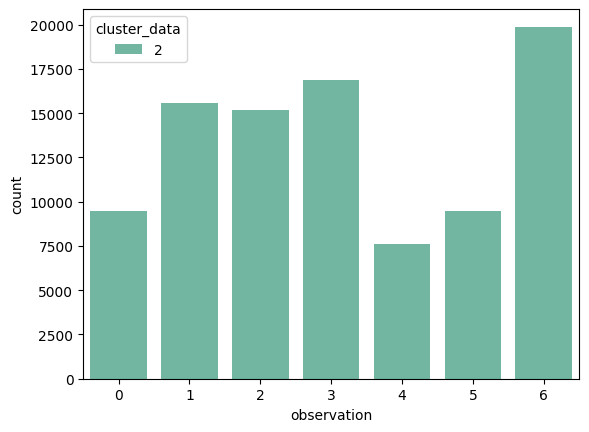

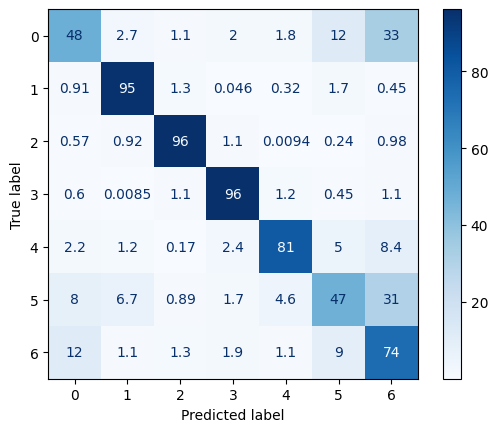

{'average_accuracy': 0.7958757124886736, 'average_f1_macro': np.float64(0.7586304878202227), 'average_f1_micro': np.float64(0.7958757124886736), 'average_auc': np.float64(0.9526870798559667), 'average_acc_kelas_generatif': 0.9515618821668644, 'average_acc_fase_padi': 0.933369784446432}
{'val_accuracy': 0.8018829246070913, 'val_f1_macro': np.float64(0.7705104788861172), 'val_f1_micro': np.float64(0.8018829246070913), 'val_auc': np.float64(0.9574102281971906), 'val_acc_kelas_generatif': 0.9557664604694518, 'val_acc_fase_padi': 0.9362439541680677, 'val_relative_acc': np.float64(99.1213328851971)}
CLUSTER:  3


[I 2024-10-24 10:27:35,818] A new study created in memory with name: no-name-07ef4e4c-9a25-42b2-8a2c-daef18a9238f


[1 2 6 3 5 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 10:28:28,961] Trial 0 finished with value: 0.7666685078029255 and parameters: {'max_depth': 10, 'learning_rate': 0.03330364604617233, 'reg_lambda': 3.3175103717418706, 'min_child_weight': 98}. Best is trial 0 with value: 0.7666685078029255.


[I 2024-10-24 10:29:01,584] Trial 1 finished with value: 0.7667252044065481 and parameters: {'max_depth': 6, 'learning_rate': 0.062332834042354124, 'reg_lambda': 2.849973603293706, 'min_child_weight': 76}. Best is trial 1 with value: 0.7667252044065481.


[I 2024-10-24 10:29:28,772] Trial 2 finished with value: 0.765840319909597 and parameters: {'max_depth': 7, 'learning_rate': 0.0682326306053583, 'reg_lambda': 4.226007338604964, 'min_child_weight': 55}. Best is trial 1 with value: 0.7667252044065481.


[I 2024-10-24 10:30:31,553] Trial 3 finished with value: 0.7588229754080049 and parameters: {'max_depth': 6, 'learning_rate': 0.011311736911901106, 'reg_lambda': 2.7523398355808153, 'min_child_weight': 67}. Best is trial 1 with value: 0.7667252044065481.


[I 2024-10-24 10:31:15,281] Trial 4 finished with value: 0.7661874578768259 and parameters: {'max_depth': 8, 'learning_rate': 0.03962007318824088, 'reg_lambda': 0.8350572329764433, 'min_child_weight': 59}. Best is trial 1 with value: 0.7667252044065481.


[I 2024-10-24 10:31:46,413] Trial 5 finished with value: 0.7666429686326693 and parameters: {'max_depth': 6, 'learning_rate': 0.06888664458855154, 'reg_lambda': 3.7276131868778335, 'min_child_weight': 93}. Best is trial 1 with value: 0.7667252044065481.


[I 2024-10-24 10:32:09,927] Trial 6 finished with value: 0.7670471859562445 and parameters: {'max_depth': 6, 'learning_rate': 0.08779144646271188, 'reg_lambda': 0.399262407266854, 'min_child_weight': 75}. Best is trial 6 with value: 0.7670471859562445.


[I 2024-10-24 10:32:37,176] Trial 7 finished with value: 0.7669814921527479 and parameters: {'max_depth': 9, 'learning_rate': 0.06880401972339628, 'reg_lambda': 4.133120633008394, 'min_child_weight': 74}. Best is trial 6 with value: 0.7670471859562445.


[I 2024-10-24 10:33:05,149] Trial 8 finished with value: 0.7672750671183332 and parameters: {'max_depth': 10, 'learning_rate': 0.06682862894084993, 'reg_lambda': 4.1456211355306545, 'min_child_weight': 68}. Best is trial 8 with value: 0.7672750671183332.


[I 2024-10-24 10:34:16,681] Trial 9 finished with value: 0.7630637766981954 and parameters: {'max_depth': 7, 'learning_rate': 0.012720733353118087, 'reg_lambda': 2.5099250805906963, 'min_child_weight': 88}. Best is trial 8 with value: 0.7672750671183332.


[I 2024-10-24 10:34:37,741] Trial 10 finished with value: 0.7670479862654745 and parameters: {'max_depth': 10, 'learning_rate': 0.09242819794730339, 'reg_lambda': 4.958361897491506, 'min_child_weight': 51}. Best is trial 8 with value: 0.7672750671183332.


[I 2024-10-24 10:34:57,439] Trial 11 finished with value: 0.7647975282370284 and parameters: {'max_depth': 10, 'learning_rate': 0.09900791035548459, 'reg_lambda': 4.9660491461714225, 'min_child_weight': 50}. Best is trial 8 with value: 0.7672750671183332.


[I 2024-10-24 10:35:20,342] Trial 12 finished with value: 0.7660996110742749 and parameters: {'max_depth': 9, 'learning_rate': 0.08530881345558114, 'reg_lambda': 4.859009171766315, 'min_child_weight': 64}. Best is trial 8 with value: 0.7672750671183332.


[I 2024-10-24 10:35:57,869] Trial 13 finished with value: 0.7686553289468309 and parameters: {'max_depth': 9, 'learning_rate': 0.04895044788159429, 'reg_lambda': 1.8370469501703646, 'min_child_weight': 83}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:36:36,531] Trial 14 finished with value: 0.7685278973100592 and parameters: {'max_depth': 9, 'learning_rate': 0.04636668890817272, 'reg_lambda': 1.8112041758297872, 'min_child_weight': 85}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:37:16,094] Trial 15 finished with value: 0.7682104132339437 and parameters: {'max_depth': 9, 'learning_rate': 0.04507739230924817, 'reg_lambda': 1.799257114637721, 'min_child_weight': 84}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:38:09,851] Trial 16 finished with value: 0.7676079502350456 and parameters: {'max_depth': 8, 'learning_rate': 0.03183667309075978, 'reg_lambda': 1.5351509937286836, 'min_child_weight': 83}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:38:42,135] Trial 17 finished with value: 0.7685811439701077 and parameters: {'max_depth': 9, 'learning_rate': 0.05384763391392949, 'reg_lambda': 1.6230831348813353, 'min_child_weight': 83}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:39:15,475] Trial 18 finished with value: 0.7678889671788384 and parameters: {'max_depth': 8, 'learning_rate': 0.054223474556950466, 'reg_lambda': 1.1871388666076061, 'min_child_weight': 93}. Best is trial 13 with value: 0.7686553289468309.


[I 2024-10-24 10:40:17,651] Trial 19 finished with value: 0.7684023262866028 and parameters: {'max_depth': 8, 'learning_rate': 0.027505660178367457, 'reg_lambda': 2.162225997856175, 'min_child_weight': 79}. Best is trial 13 with value: 0.7686553289468309.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.04895044788159429, 'reg_lambda': 1.8370469501703646, 'min_child_weight': 83}
Best Score: 0.7686553289468309
Start the modelling
[0]	train-mlogloss:1.85458	eval-mlogloss:1.85546


[100]	train-mlogloss:0.34690	eval-mlogloss:0.54496


[200]	train-mlogloss:0.21202	eval-mlogloss:0.48898


[300]	train-mlogloss:0.14365	eval-mlogloss:0.47487


[400]	train-mlogloss:0.10364	eval-mlogloss:0.47133


[500]	train-mlogloss:0.07726	eval-mlogloss:0.47243


[600]	train-mlogloss:0.06046	eval-mlogloss:0.47548


[700]	train-mlogloss:0.04859	eval-mlogloss:0.48080


[800]	train-mlogloss:0.04062	eval-mlogloss:0.48567


[900]	train-mlogloss:0.03476	eval-mlogloss:0.49051


[1000]	train-mlogloss:0.03032	eval-mlogloss:0.49544


[1100]	train-mlogloss:0.02693	eval-mlogloss:0.50016


[1200]	train-mlogloss:0.02423	eval-mlogloss:0.50447


[1300]	train-mlogloss:0.02199	eval-mlogloss:0.50888


[1400]	train-mlogloss:0.02014	eval-mlogloss:0.51285


[1431]	train-mlogloss:0.01965	eval-mlogloss:0.51433


[0]	train-mlogloss:1.85453	eval-mlogloss:1.85511


[100]	train-mlogloss:0.34099	eval-mlogloss:0.53861


[200]	train-mlogloss:0.20878	eval-mlogloss:0.48358


[300]	train-mlogloss:0.14391	eval-mlogloss:0.47101


[400]	train-mlogloss:0.10142	eval-mlogloss:0.46817


[500]	train-mlogloss:0.07609	eval-mlogloss:0.47095


[600]	train-mlogloss:0.05993	eval-mlogloss:0.47488


[700]	train-mlogloss:0.04846	eval-mlogloss:0.48018


[800]	train-mlogloss:0.04076	eval-mlogloss:0.48563


[900]	train-mlogloss:0.03496	eval-mlogloss:0.49079


[1000]	train-mlogloss:0.03068	eval-mlogloss:0.49620


[1100]	train-mlogloss:0.02726	eval-mlogloss:0.50091


[1200]	train-mlogloss:0.02453	eval-mlogloss:0.50549


[1300]	train-mlogloss:0.02228	eval-mlogloss:0.50985


[1394]	train-mlogloss:0.02059	eval-mlogloss:0.51392


[0]	train-mlogloss:1.85452	eval-mlogloss:1.85546


[100]	train-mlogloss:0.34529	eval-mlogloss:0.54580


[200]	train-mlogloss:0.20409	eval-mlogloss:0.49346


[300]	train-mlogloss:0.14021	eval-mlogloss:0.48351


[400]	train-mlogloss:0.10071	eval-mlogloss:0.48383


[500]	train-mlogloss:0.07607	eval-mlogloss:0.48694


[600]	train-mlogloss:0.06055	eval-mlogloss:0.49179


[700]	train-mlogloss:0.04924	eval-mlogloss:0.49792


[800]	train-mlogloss:0.04082	eval-mlogloss:0.50458


[900]	train-mlogloss:0.03473	eval-mlogloss:0.51080


[1000]	train-mlogloss:0.03042	eval-mlogloss:0.51658


[1100]	train-mlogloss:0.02697	eval-mlogloss:0.52174


[1200]	train-mlogloss:0.02419	eval-mlogloss:0.52700


[1300]	train-mlogloss:0.02194	eval-mlogloss:0.53193


[1339]	train-mlogloss:0.02120	eval-mlogloss:0.53372


[0]	train-mlogloss:1.85369	eval-mlogloss:1.85366


[50]	train-mlogloss:0.58361	eval-mlogloss:0.68288


[100]	train-mlogloss:0.36669	eval-mlogloss:0.53539


[150]	train-mlogloss:0.28754	eval-mlogloss:0.49697


[200]	train-mlogloss:0.24156	eval-mlogloss:0.48041


[250]	train-mlogloss:0.20265	eval-mlogloss:0.47063


[300]	train-mlogloss:0.17398	eval-mlogloss:0.46483


[350]	train-mlogloss:0.15042	eval-mlogloss:0.46146


[400]	train-mlogloss:0.13063	eval-mlogloss:0.45934


[450]	train-mlogloss:0.11324	eval-mlogloss:0.45834


[500]	train-mlogloss:0.09852	eval-mlogloss:0.45832


[529]	train-mlogloss:0.09147	eval-mlogloss:0.45868



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.56      0.41      0.47      6474
           1       0.85      0.89      0.87     13183
           2       0.93      0.94      0.94     13212
           3       0.92      0.92      0.92     13379
           4       0.82      0.88      0.85     12884
           5       0.51      0.44      0.47      6660
           6       0.87      0.95      0.91     10247

    accuracy                           0.83     76039
   macro avg       0.78      0.78      0.78     76039
weighted avg       0.82      0.83      0.82     76039



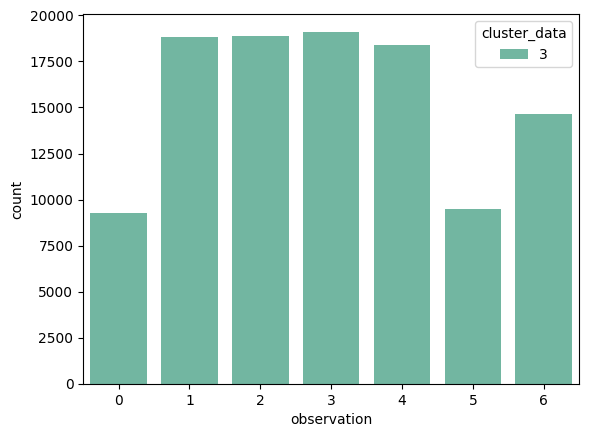

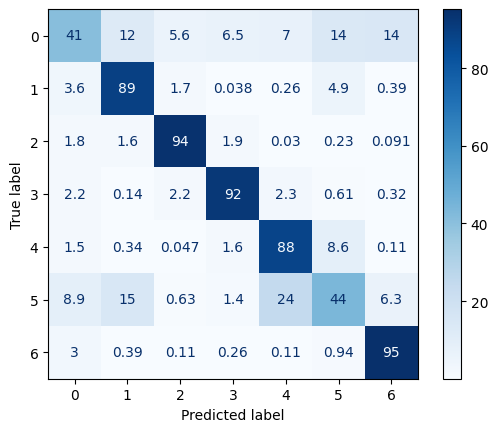

{'average_accuracy': 0.8283670542556099, 'average_f1_macro': np.float64(0.7681477941733856), 'average_f1_micro': np.float64(0.8283670542556099), 'average_auc': np.float64(0.9612876174628643), 'average_acc_kelas_generatif': 0.9283230135740596, 'average_acc_fase_padi': 0.9127045049086903}
{'val_accuracy': 0.830652691382054, 'val_f1_macro': np.float64(0.7755379977816445), 'val_f1_micro': np.float64(0.830652691382054), 'val_auc': np.float64(0.9640503533800306), 'val_acc_kelas_generatif': 0.922116750130802, 'val_acc_fase_padi': 0.908541911960196, 'val_relative_acc': np.float64(99.36637764594376)}
CLUSTER:  4


[I 2024-10-24 10:42:21,254] A new study created in memory with name: no-name-d1c8fa1c-a952-4ea4-93fb-ddd5e4a24b3a


[6 1 2 3 4 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 10:42:43,307] Trial 0 finished with value: 0.7673013730965598 and parameters: {'max_depth': 8, 'learning_rate': 0.09012124156888662, 'reg_lambda': 0.9124388747022194, 'min_child_weight': 68}. Best is trial 0 with value: 0.7673013730965598.


[I 2024-10-24 10:43:18,793] Trial 1 finished with value: 0.7653605307919965 and parameters: {'max_depth': 8, 'learning_rate': 0.058416309622671435, 'reg_lambda': 3.7654078379152076, 'min_child_weight': 96}. Best is trial 0 with value: 0.7673013730965598.


[I 2024-10-24 10:43:48,488] Trial 2 finished with value: 0.7686006120884539 and parameters: {'max_depth': 10, 'learning_rate': 0.06611169987770885, 'reg_lambda': 4.769129166891595, 'min_child_weight': 64}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:44:45,545] Trial 3 finished with value: 0.760667403808414 and parameters: {'max_depth': 6, 'learning_rate': 0.019634308804777425, 'reg_lambda': 4.845461057122665, 'min_child_weight': 50}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:45:23,557] Trial 4 finished with value: 0.7660190439286158 and parameters: {'max_depth': 6, 'learning_rate': 0.05435213000053908, 'reg_lambda': 4.767340893375769, 'min_child_weight': 57}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:46:15,862] Trial 5 finished with value: 0.7657443834637331 and parameters: {'max_depth': 7, 'learning_rate': 0.03685679011426516, 'reg_lambda': 0.4851353988083107, 'min_child_weight': 53}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:47:37,608] Trial 6 finished with value: 0.7677702186378698 and parameters: {'max_depth': 9, 'learning_rate': 0.02256393734963792, 'reg_lambda': 4.148566989139753, 'min_child_weight': 60}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:48:37,796] Trial 7 finished with value: 0.7683844683880211 and parameters: {'max_depth': 8, 'learning_rate': 0.03154088962217888, 'reg_lambda': 1.7490818807973936, 'min_child_weight': 66}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:49:19,217] Trial 8 finished with value: 0.7674295935116723 and parameters: {'max_depth': 10, 'learning_rate': 0.048878113012000166, 'reg_lambda': 3.4448211230446435, 'min_child_weight': 67}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:49:40,076] Trial 9 finished with value: 0.7664361635924449 and parameters: {'max_depth': 9, 'learning_rate': 0.09961269485902284, 'reg_lambda': 0.37144668904654443, 'min_child_weight': 60}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:50:07,433] Trial 10 finished with value: 0.7657624691404092 and parameters: {'max_depth': 10, 'learning_rate': 0.07624476889529208, 'reg_lambda': 2.7804688089079828, 'min_child_weight': 84}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:50:34,973] Trial 11 finished with value: 0.7667120780714122 and parameters: {'max_depth': 9, 'learning_rate': 0.07335435032533269, 'reg_lambda': 1.4638729545242894, 'min_child_weight': 78}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:51:32,009] Trial 12 finished with value: 0.765676927021555 and parameters: {'max_depth': 7, 'learning_rate': 0.03584647209179717, 'reg_lambda': 2.1161211630540837, 'min_child_weight': 70}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:52:04,056] Trial 13 finished with value: 0.7665707398244236 and parameters: {'max_depth': 7, 'learning_rate': 0.06971749615674676, 'reg_lambda': 2.3342093435608304, 'min_child_weight': 78}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:53:35,669] Trial 14 finished with value: 0.7635048665992477 and parameters: {'max_depth': 9, 'learning_rate': 0.012343231130490375, 'reg_lambda': 1.6998780433527951, 'min_child_weight': 88}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:54:30,384] Trial 15 finished with value: 0.7679914573806098 and parameters: {'max_depth': 10, 'learning_rate': 0.03651629957510019, 'reg_lambda': 3.0350857559354454, 'min_child_weight': 64}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:55:14,268] Trial 16 finished with value: 0.7671813304182168 and parameters: {'max_depth': 8, 'learning_rate': 0.049322735689975215, 'reg_lambda': 1.405241861250115, 'min_child_weight': 73}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:55:47,760] Trial 17 finished with value: 0.7659112936979069 and parameters: {'max_depth': 7, 'learning_rate': 0.06520871827734626, 'reg_lambda': 2.096494494287834, 'min_child_weight': 63}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:56:14,321] Trial 18 finished with value: 0.7671110116939182 and parameters: {'max_depth': 9, 'learning_rate': 0.08115674885999202, 'reg_lambda': 4.377850769405117, 'min_child_weight': 55}. Best is trial 2 with value: 0.7686006120884539.


[I 2024-10-24 10:57:29,154] Trial 19 finished with value: 0.7675371604542383 and parameters: {'max_depth': 8, 'learning_rate': 0.025354259133029987, 'reg_lambda': 3.4480440417450366, 'min_child_weight': 77}. Best is trial 2 with value: 0.7686006120884539.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.06611169987770885, 'reg_lambda': 4.769129166891595, 'min_child_weight': 64}
Best Score: 0.7686006120884539
Start the modelling
[0]	train-mlogloss:1.81995	eval-mlogloss:1.82354


[100]	train-mlogloss:0.24634	eval-mlogloss:0.52551


[200]	train-mlogloss:0.13784	eval-mlogloss:0.49084


[300]	train-mlogloss:0.08398	eval-mlogloss:0.48610


[400]	train-mlogloss:0.05907	eval-mlogloss:0.49093


[500]	train-mlogloss:0.04424	eval-mlogloss:0.49670


[600]	train-mlogloss:0.03547	eval-mlogloss:0.50360


[700]	train-mlogloss:0.02909	eval-mlogloss:0.51095


[800]	train-mlogloss:0.02468	eval-mlogloss:0.51854


[900]	train-mlogloss:0.02143	eval-mlogloss:0.52486


[1000]	train-mlogloss:0.01887	eval-mlogloss:0.53051


[1100]	train-mlogloss:0.01699	eval-mlogloss:0.53558


[1200]	train-mlogloss:0.01543	eval-mlogloss:0.54046


[1275]	train-mlogloss:0.01442	eval-mlogloss:0.54405


[0]	train-mlogloss:1.82041	eval-mlogloss:1.82399


[100]	train-mlogloss:0.24444	eval-mlogloss:0.52354


[200]	train-mlogloss:0.13310	eval-mlogloss:0.48737


[300]	train-mlogloss:0.08291	eval-mlogloss:0.48243


[400]	train-mlogloss:0.05734	eval-mlogloss:0.48570


[500]	train-mlogloss:0.04302	eval-mlogloss:0.49124


[600]	train-mlogloss:0.03452	eval-mlogloss:0.49838


[700]	train-mlogloss:0.02867	eval-mlogloss:0.50492


[800]	train-mlogloss:0.02427	eval-mlogloss:0.51146


[900]	train-mlogloss:0.02128	eval-mlogloss:0.51705


[1000]	train-mlogloss:0.01873	eval-mlogloss:0.52270


[1100]	train-mlogloss:0.01681	eval-mlogloss:0.52719


[1200]	train-mlogloss:0.01532	eval-mlogloss:0.53196


[1294]	train-mlogloss:0.01413	eval-mlogloss:0.53618


[0]	train-mlogloss:1.82010	eval-mlogloss:1.82422


[100]	train-mlogloss:0.24744	eval-mlogloss:0.52509


[200]	train-mlogloss:0.13361	eval-mlogloss:0.48870


[300]	train-mlogloss:0.08439	eval-mlogloss:0.48350


[400]	train-mlogloss:0.05991	eval-mlogloss:0.48688


[500]	train-mlogloss:0.04558	eval-mlogloss:0.49156


[600]	train-mlogloss:0.03634	eval-mlogloss:0.49712


[700]	train-mlogloss:0.02971	eval-mlogloss:0.50371


[800]	train-mlogloss:0.02495	eval-mlogloss:0.50982


[900]	train-mlogloss:0.02164	eval-mlogloss:0.51576


[1000]	train-mlogloss:0.01908	eval-mlogloss:0.52205


[1100]	train-mlogloss:0.01706	eval-mlogloss:0.52706


[1200]	train-mlogloss:0.01535	eval-mlogloss:0.53205


[1292]	train-mlogloss:0.01410	eval-mlogloss:0.53651


[0]	train-mlogloss:1.81910	eval-mlogloss:1.82183


[50]	train-mlogloss:0.43790	eval-mlogloss:0.60912


[100]	train-mlogloss:0.27155	eval-mlogloss:0.51024


[150]	train-mlogloss:0.20498	eval-mlogloss:0.48359


[200]	train-mlogloss:0.15902	eval-mlogloss:0.47101


[250]	train-mlogloss:0.12463	eval-mlogloss:0.46463


[300]	train-mlogloss:0.10177	eval-mlogloss:0.46151


[350]	train-mlogloss:0.08430	eval-mlogloss:0.46074


[400]	train-mlogloss:0.07146	eval-mlogloss:0.46134


[408]	train-mlogloss:0.06964	eval-mlogloss:0.46148



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.50      0.34      0.41      6684
           1       0.89      0.93      0.91     12669
           2       0.95      0.95      0.95     12351
           3       0.93      0.94      0.94     12928
           4       0.90      0.96      0.93     10494
           5       0.62      0.46      0.53      6556
           6       0.71      0.83      0.76     13819

    accuracy                           0.83     75501
   macro avg       0.79      0.77      0.78     75501
weighted avg       0.82      0.83      0.82     75501



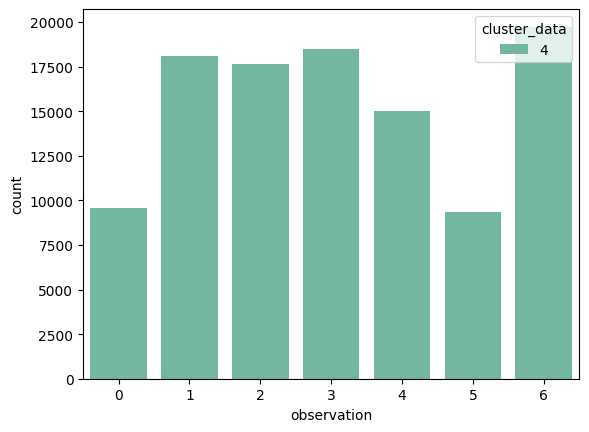

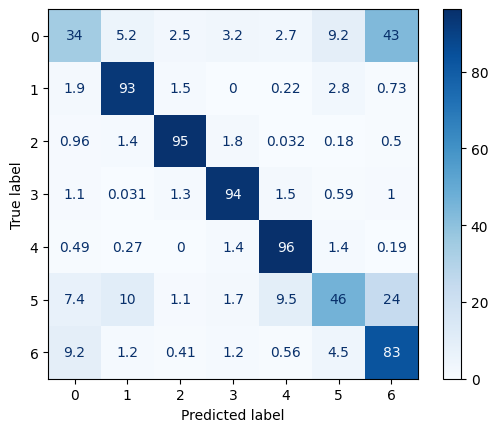

{'average_accuracy': 0.8243655679507852, 'average_f1_macro': np.float64(0.7681317833189212), 'average_f1_micro': np.float64(0.8243655679507852), 'average_auc': np.float64(0.9596870961247608), 'average_acc_kelas_generatif': 0.9379062960775216, 'average_acc_fase_padi': 0.9432589616939039}
{'val_accuracy': 0.82922080502245, 'val_f1_macro': np.float64(0.7757430218776975), 'val_f1_micro': np.float64(0.82922080502245), 'val_auc': np.float64(0.9627993096179192), 'val_acc_kelas_generatif': 0.9446936881188119, 'val_acc_fase_padi': 0.946224350769993, 'val_relative_acc': np.float64(99.33202810088679)}
CLUSTER:  5


[I 2024-10-24 10:59:20,075] A new study created in memory with name: no-name-816ddbf7-2cdb-42df-8ed3-427f40ec9b39


[6 2 4 3 1 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 11:00:12,050] Trial 0 finished with value: 0.5479438754329057 and parameters: {'max_depth': 7, 'learning_rate': 0.016826282771132156, 'reg_lambda': 4.252825990882851, 'min_child_weight': 89}. Best is trial 0 with value: 0.5479438754329057.


[I 2024-10-24 11:00:45,877] Trial 1 finished with value: 0.5477854773624616 and parameters: {'max_depth': 6, 'learning_rate': 0.029561521754994526, 'reg_lambda': 0.7893908014277118, 'min_child_weight': 61}. Best is trial 0 with value: 0.5479438754329057.


[I 2024-10-24 11:01:00,464] Trial 2 finished with value: 0.5455522600075391 and parameters: {'max_depth': 7, 'learning_rate': 0.09550982268527847, 'reg_lambda': 1.5938500060270278, 'min_child_weight': 98}. Best is trial 0 with value: 0.5479438754329057.


[I 2024-10-24 11:01:16,313] Trial 3 finished with value: 0.5524471354242434 and parameters: {'max_depth': 10, 'learning_rate': 0.08978125287289805, 'reg_lambda': 4.938174439921638, 'min_child_weight': 51}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:01:33,222] Trial 4 finished with value: 0.5467080248724976 and parameters: {'max_depth': 7, 'learning_rate': 0.07241287227159597, 'reg_lambda': 3.504100413442605, 'min_child_weight': 66}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:01:49,802] Trial 5 finished with value: 0.5493337009203499 and parameters: {'max_depth': 8, 'learning_rate': 0.07776060838327431, 'reg_lambda': 1.4306272502590738, 'min_child_weight': 58}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:02:32,223] Trial 6 finished with value: 0.5471551763456438 and parameters: {'max_depth': 6, 'learning_rate': 0.022266170385125232, 'reg_lambda': 1.9093974280081212, 'min_child_weight': 83}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:03:10,287] Trial 7 finished with value: 0.5513414991848969 and parameters: {'max_depth': 9, 'learning_rate': 0.0319724393610851, 'reg_lambda': 2.6597585154488046, 'min_child_weight': 75}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:03:27,444] Trial 8 finished with value: 0.5502535510742566 and parameters: {'max_depth': 9, 'learning_rate': 0.07870286376787128, 'reg_lambda': 0.6431034279749727, 'min_child_weight': 69}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:04:02,421] Trial 9 finished with value: 0.5456258003204613 and parameters: {'max_depth': 6, 'learning_rate': 0.026614264497749153, 'reg_lambda': 2.810221978746408, 'min_child_weight': 88}. Best is trial 3 with value: 0.5524471354242434.


[I 2024-10-24 11:04:28,595] Trial 10 finished with value: 0.5537891204167532 and parameters: {'max_depth': 10, 'learning_rate': 0.049485204129303066, 'reg_lambda': 4.991928134964745, 'min_child_weight': 50}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:04:55,593] Trial 11 finished with value: 0.5517471078298333 and parameters: {'max_depth': 10, 'learning_rate': 0.04982213550542336, 'reg_lambda': 4.639248767852735, 'min_child_weight': 51}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:05:24,071] Trial 12 finished with value: 0.5534530104577223 and parameters: {'max_depth': 10, 'learning_rate': 0.04989794764160003, 'reg_lambda': 4.8615572544376136, 'min_child_weight': 50}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:05:51,897] Trial 13 finished with value: 0.551382368130251 and parameters: {'max_depth': 9, 'learning_rate': 0.0469354584409945, 'reg_lambda': 3.85370635515332, 'min_child_weight': 50}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:06:14,190] Trial 14 finished with value: 0.5533692536989484 and parameters: {'max_depth': 10, 'learning_rate': 0.0622331868670738, 'reg_lambda': 3.477484335835734, 'min_child_weight': 59}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:06:47,142] Trial 15 finished with value: 0.5525506873791985 and parameters: {'max_depth': 9, 'learning_rate': 0.0398579269297025, 'reg_lambda': 4.3391237195803765, 'min_child_weight': 57}. Best is trial 10 with value: 0.5537891204167532.


[I 2024-10-24 11:07:08,999] Trial 16 finished with value: 0.5540088711124479 and parameters: {'max_depth': 10, 'learning_rate': 0.0618181357860016, 'reg_lambda': 4.877042299598486, 'min_child_weight': 71}. Best is trial 16 with value: 0.5540088711124479.


[I 2024-10-24 11:07:30,320] Trial 17 finished with value: 0.5498625013772664 and parameters: {'max_depth': 8, 'learning_rate': 0.062159921973428095, 'reg_lambda': 3.6933709645876296, 'min_child_weight': 77}. Best is trial 16 with value: 0.5540088711124479.


[I 2024-10-24 11:07:52,845] Trial 18 finished with value: 0.5534365774052245 and parameters: {'max_depth': 10, 'learning_rate': 0.061935373994894, 'reg_lambda': 3.048552712897166, 'min_child_weight': 70}. Best is trial 16 with value: 0.5540088711124479.


[I 2024-10-24 11:08:11,640] Trial 19 finished with value: 0.5476657115955201 and parameters: {'max_depth': 9, 'learning_rate': 0.0694552963989857, 'reg_lambda': 2.1825675085665126, 'min_child_weight': 98}. Best is trial 16 with value: 0.5540088711124479.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.0618181357860016, 'reg_lambda': 4.877042299598486, 'min_child_weight': 71}
Best Score: 0.5540088711124479
Start the modelling
[0]	train-mlogloss:1.86794	eval-mlogloss:1.89207


[100]	train-mlogloss:0.64643	eval-mlogloss:1.23914


[200]	train-mlogloss:0.42562	eval-mlogloss:1.22518


[300]	train-mlogloss:0.29258	eval-mlogloss:1.22880


[400]	train-mlogloss:0.21246	eval-mlogloss:1.23804


[500]	train-mlogloss:0.16212	eval-mlogloss:1.25065


[600]	train-mlogloss:0.12866	eval-mlogloss:1.26531


[700]	train-mlogloss:0.10399	eval-mlogloss:1.27971


[800]	train-mlogloss:0.08653	eval-mlogloss:1.29453


[900]	train-mlogloss:0.07360	eval-mlogloss:1.30812


[1000]	train-mlogloss:0.06452	eval-mlogloss:1.32154


[1100]	train-mlogloss:0.05717	eval-mlogloss:1.33312


[1196]	train-mlogloss:0.05162	eval-mlogloss:1.34385


[0]	train-mlogloss:1.86856	eval-mlogloss:1.89030


[100]	train-mlogloss:0.64904	eval-mlogloss:1.23126


[200]	train-mlogloss:0.42888	eval-mlogloss:1.21690


[300]	train-mlogloss:0.29747	eval-mlogloss:1.22164


[400]	train-mlogloss:0.22056	eval-mlogloss:1.23318


[500]	train-mlogloss:0.16910	eval-mlogloss:1.24925


[600]	train-mlogloss:0.13265	eval-mlogloss:1.26472


[700]	train-mlogloss:0.10870	eval-mlogloss:1.28106


[800]	train-mlogloss:0.09041	eval-mlogloss:1.29624


[900]	train-mlogloss:0.07698	eval-mlogloss:1.31122


[1000]	train-mlogloss:0.06656	eval-mlogloss:1.32605


[1100]	train-mlogloss:0.05886	eval-mlogloss:1.33884


[1200]	train-mlogloss:0.05228	eval-mlogloss:1.35158


[0]	train-mlogloss:1.86851	eval-mlogloss:1.89070


[100]	train-mlogloss:0.64059	eval-mlogloss:1.23033


[200]	train-mlogloss:0.41776	eval-mlogloss:1.21428


[300]	train-mlogloss:0.28970	eval-mlogloss:1.21682


[400]	train-mlogloss:0.20955	eval-mlogloss:1.22543


[500]	train-mlogloss:0.15863	eval-mlogloss:1.23806


[600]	train-mlogloss:0.12503	eval-mlogloss:1.25247


[700]	train-mlogloss:0.10216	eval-mlogloss:1.26606


[800]	train-mlogloss:0.08526	eval-mlogloss:1.28001


[900]	train-mlogloss:0.07303	eval-mlogloss:1.29331


[1000]	train-mlogloss:0.06354	eval-mlogloss:1.30772


[1100]	train-mlogloss:0.05592	eval-mlogloss:1.32027


[1200]	train-mlogloss:0.04978	eval-mlogloss:1.33169


[1208]	train-mlogloss:0.04940	eval-mlogloss:1.33235


[0]	train-mlogloss:1.86837	eval-mlogloss:1.89034


[50]	train-mlogloss:0.89545	eval-mlogloss:1.28174


[100]	train-mlogloss:0.70050	eval-mlogloss:1.23111


[150]	train-mlogloss:0.57805	eval-mlogloss:1.21934


[200]	train-mlogloss:0.47990	eval-mlogloss:1.21478


[250]	train-mlogloss:0.40399	eval-mlogloss:1.21362


[299]	train-mlogloss:0.34670	eval-mlogloss:1.21428



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.35      0.28      0.31      6638
           1       0.78      0.72      0.75      4631
           2       0.73      0.66      0.69      5427
           3       0.88      0.93      0.90      5422
           4       0.38      0.42      0.40      6864
           5       0.32      0.27      0.29      6668
           6       0.51      0.59      0.55     13936

    accuracy                           0.54     49586
   macro avg       0.56      0.55      0.56     49586
weighted avg       0.53      0.54      0.53     49586



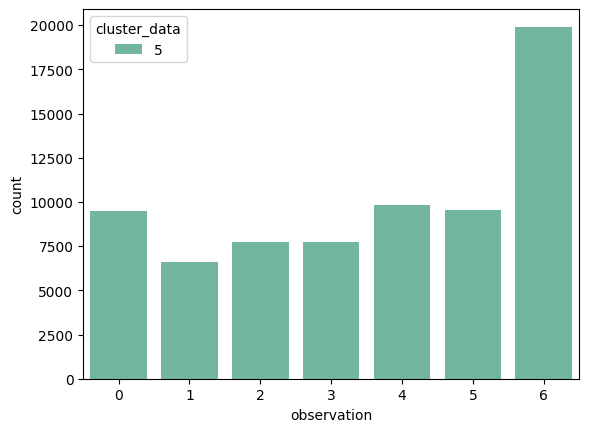

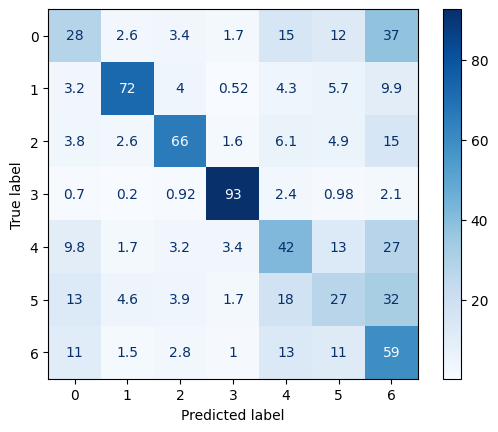

{'average_accuracy': 0.5447273979399276, 'average_f1_macro': np.float64(0.552817093086798), 'average_f1_micro': np.float64(0.5447273979399276), 'average_auc': np.float64(0.8301647119963124), 'average_acc_kelas_generatif': 0.9311561223639243, 'average_acc_fase_padi': 0.6472431503651156}
{'val_accuracy': 0.5395272859274796, 'val_f1_macro': np.float64(0.5563588253259107), 'val_f1_micro': np.float64(0.5395272859274796), 'val_auc': np.float64(0.8358183250124148), 'val_acc_kelas_generatif': 0.9269642198450756, 'val_acc_fase_padi': 0.6636680988184748, 'val_relative_acc': np.float64(92.64123122292877)}
CLUSTER:  6


[I 2024-10-24 11:09:46,024] A new study created in memory with name: no-name-2fa6e82c-5f7b-4943-961a-6688a52ef731


[6 5 2 4 0 1 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 11:10:50,778] Trial 0 finished with value: 0.6271294154567073 and parameters: {'max_depth': 9, 'learning_rate': 0.02451996325272128, 'reg_lambda': 0.40753110045875196, 'min_child_weight': 90}. Best is trial 0 with value: 0.6271294154567073.


[I 2024-10-24 11:11:37,995] Trial 1 finished with value: 0.6282562583572007 and parameters: {'max_depth': 10, 'learning_rate': 0.035282872406208456, 'reg_lambda': 4.697672274500064, 'min_child_weight': 62}. Best is trial 1 with value: 0.6282562583572007.


[I 2024-10-24 11:12:06,261] Trial 2 finished with value: 0.6290566351934358 and parameters: {'max_depth': 10, 'learning_rate': 0.06263280004888062, 'reg_lambda': 0.2684996935298817, 'min_child_weight': 77}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:12:31,671] Trial 3 finished with value: 0.6274419432220698 and parameters: {'max_depth': 10, 'learning_rate': 0.06703905497370598, 'reg_lambda': 2.555900719610957, 'min_child_weight': 59}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:13:45,419] Trial 4 finished with value: 0.6250870437236132 and parameters: {'max_depth': 8, 'learning_rate': 0.013701453893259294, 'reg_lambda': 3.211853592094846, 'min_child_weight': 74}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:14:47,580] Trial 5 finished with value: 0.6254224063900783 and parameters: {'max_depth': 7, 'learning_rate': 0.015953639577377603, 'reg_lambda': 2.473475207456162, 'min_child_weight': 75}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:15:09,489] Trial 6 finished with value: 0.6273266527779812 and parameters: {'max_depth': 6, 'learning_rate': 0.08184229597635724, 'reg_lambda': 3.919900137454302, 'min_child_weight': 76}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:16:12,559] Trial 7 finished with value: 0.6264261855882672 and parameters: {'max_depth': 9, 'learning_rate': 0.025902040173780255, 'reg_lambda': 1.976579414567178, 'min_child_weight': 91}. Best is trial 2 with value: 0.6290566351934358.


[I 2024-10-24 11:16:40,779] Trial 8 finished with value: 0.6316468321265863 and parameters: {'max_depth': 9, 'learning_rate': 0.058660774570884096, 'reg_lambda': 3.7561591696264296, 'min_child_weight': 56}. Best is trial 8 with value: 0.6316468321265863.


[I 2024-10-24 11:17:33,250] Trial 9 finished with value: 0.6324274222059257 and parameters: {'max_depth': 8, 'learning_rate': 0.03320255519189997, 'reg_lambda': 4.216437674794988, 'min_child_weight': 83}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:18:11,577] Trial 10 finished with value: 0.6275310012958863 and parameters: {'max_depth': 7, 'learning_rate': 0.04353649699584397, 'reg_lambda': 4.88380027243522, 'min_child_weight': 100}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:18:46,326] Trial 11 finished with value: 0.629848257929945 and parameters: {'max_depth': 8, 'learning_rate': 0.048704884086122224, 'reg_lambda': 3.7593477694239263, 'min_child_weight': 54}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:19:06,288] Trial 12 finished with value: 0.6283457983322892 and parameters: {'max_depth': 9, 'learning_rate': 0.09840774133612853, 'reg_lambda': 3.9913593748689546, 'min_child_weight': 65}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:19:32,837] Trial 13 finished with value: 0.6285800792034065 and parameters: {'max_depth': 7, 'learning_rate': 0.06775865434395867, 'reg_lambda': 3.218104670314643, 'min_child_weight': 51}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:20:15,254] Trial 14 finished with value: 0.6285198849378001 and parameters: {'max_depth': 8, 'learning_rate': 0.038534317026619504, 'reg_lambda': 4.363177962037207, 'min_child_weight': 85}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:20:47,699] Trial 15 finished with value: 0.6300832853349364 and parameters: {'max_depth': 9, 'learning_rate': 0.053732726870877386, 'reg_lambda': 3.0580302856898416, 'min_child_weight': 68}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:21:11,915] Trial 16 finished with value: 0.6269186245078081 and parameters: {'max_depth': 6, 'learning_rate': 0.07530129255603528, 'reg_lambda': 1.2244188148028707, 'min_child_weight': 84}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:22:07,255] Trial 17 finished with value: 0.6280580125603342 and parameters: {'max_depth': 8, 'learning_rate': 0.03056451895292066, 'reg_lambda': 4.337704590504295, 'min_child_weight': 69}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:22:30,673] Trial 18 finished with value: 0.6291706552913793 and parameters: {'max_depth': 9, 'learning_rate': 0.08492951504912097, 'reg_lambda': 3.599439659292434, 'min_child_weight': 100}. Best is trial 9 with value: 0.6324274222059257.


[I 2024-10-24 11:23:03,005] Trial 19 finished with value: 0.6273213505580507 and parameters: {'max_depth': 7, 'learning_rate': 0.05450291679614679, 'reg_lambda': 2.1983092693549233, 'min_child_weight': 83}. Best is trial 9 with value: 0.6324274222059257.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.03320255519189997, 'reg_lambda': 4.216437674794988, 'min_child_weight': 83}
Best Score: 0.6324274222059257
Start the modelling
[0]	train-mlogloss:1.90144	eval-mlogloss:1.90469


[100]	train-mlogloss:0.80952	eval-mlogloss:1.00634


[200]	train-mlogloss:0.64060	eval-mlogloss:0.93220


[300]	train-mlogloss:0.54128	eval-mlogloss:0.91130


[400]	train-mlogloss:0.46508	eval-mlogloss:0.90214


[500]	train-mlogloss:0.40019	eval-mlogloss:0.89674


[600]	train-mlogloss:0.34954	eval-mlogloss:0.89363


[700]	train-mlogloss:0.30327	eval-mlogloss:0.89306


[800]	train-mlogloss:0.26491	eval-mlogloss:0.89313


[900]	train-mlogloss:0.23237	eval-mlogloss:0.89423


[1000]	train-mlogloss:0.20571	eval-mlogloss:0.89685


[1100]	train-mlogloss:0.18321	eval-mlogloss:0.90015


[1200]	train-mlogloss:0.16481	eval-mlogloss:0.90406


[1300]	train-mlogloss:0.14889	eval-mlogloss:0.90806


[1400]	train-mlogloss:0.13549	eval-mlogloss:0.91238


[1500]	train-mlogloss:0.12391	eval-mlogloss:0.91653


[1600]	train-mlogloss:0.11343	eval-mlogloss:0.92086


[1700]	train-mlogloss:0.10377	eval-mlogloss:0.92593


[1739]	train-mlogloss:0.10026	eval-mlogloss:0.92793


[0]	train-mlogloss:1.90145	eval-mlogloss:1.90487


[100]	train-mlogloss:0.80338	eval-mlogloss:1.00521


[200]	train-mlogloss:0.63050	eval-mlogloss:0.92955


[300]	train-mlogloss:0.54009	eval-mlogloss:0.90907


[400]	train-mlogloss:0.46356	eval-mlogloss:0.89759


[500]	train-mlogloss:0.39768	eval-mlogloss:0.89092


[600]	train-mlogloss:0.34113	eval-mlogloss:0.88717


[700]	train-mlogloss:0.29757	eval-mlogloss:0.88573


[800]	train-mlogloss:0.26265	eval-mlogloss:0.88609


[900]	train-mlogloss:0.23196	eval-mlogloss:0.88748


[1000]	train-mlogloss:0.20571	eval-mlogloss:0.88946


[1100]	train-mlogloss:0.18464	eval-mlogloss:0.89204


[1200]	train-mlogloss:0.16732	eval-mlogloss:0.89519


[1300]	train-mlogloss:0.15004	eval-mlogloss:0.89851


[1400]	train-mlogloss:0.13727	eval-mlogloss:0.90294


[1500]	train-mlogloss:0.12466	eval-mlogloss:0.90711


[1600]	train-mlogloss:0.11462	eval-mlogloss:0.91176


[1700]	train-mlogloss:0.10490	eval-mlogloss:0.91651


[1736]	train-mlogloss:0.10193	eval-mlogloss:0.91827


[0]	train-mlogloss:1.90130	eval-mlogloss:1.90428


[100]	train-mlogloss:0.80928	eval-mlogloss:1.00513


[200]	train-mlogloss:0.63490	eval-mlogloss:0.92989


[300]	train-mlogloss:0.53660	eval-mlogloss:0.90836


[400]	train-mlogloss:0.45797	eval-mlogloss:0.89697


[500]	train-mlogloss:0.39124	eval-mlogloss:0.89117


[600]	train-mlogloss:0.33814	eval-mlogloss:0.88811


[700]	train-mlogloss:0.29394	eval-mlogloss:0.88716


[800]	train-mlogloss:0.25662	eval-mlogloss:0.88753


[900]	train-mlogloss:0.22664	eval-mlogloss:0.88913


[1000]	train-mlogloss:0.20174	eval-mlogloss:0.89149


[1100]	train-mlogloss:0.17954	eval-mlogloss:0.89424


[1200]	train-mlogloss:0.16155	eval-mlogloss:0.89762


[1300]	train-mlogloss:0.14520	eval-mlogloss:0.90179


[1400]	train-mlogloss:0.13235	eval-mlogloss:0.90593


[1500]	train-mlogloss:0.12007	eval-mlogloss:0.90994


[1600]	train-mlogloss:0.10995	eval-mlogloss:0.91396


[1700]	train-mlogloss:0.10093	eval-mlogloss:0.91857


[1714]	train-mlogloss:0.09995	eval-mlogloss:0.91921


[0]	train-mlogloss:1.90147	eval-mlogloss:1.90407


[50]	train-mlogloss:1.05901	eval-mlogloss:1.15557


[100]	train-mlogloss:0.83056	eval-mlogloss:0.99604


[150]	train-mlogloss:0.72754	eval-mlogloss:0.94130


[200]	train-mlogloss:0.66932	eval-mlogloss:0.91841


[250]	train-mlogloss:0.62416	eval-mlogloss:0.90600


[300]	train-mlogloss:0.58567	eval-mlogloss:0.89765


[350]	train-mlogloss:0.54867	eval-mlogloss:0.89135


[400]	train-mlogloss:0.51565	eval-mlogloss:0.88634


[450]	train-mlogloss:0.48374	eval-mlogloss:0.88223


[500]	train-mlogloss:0.45490	eval-mlogloss:0.87912


[550]	train-mlogloss:0.42738	eval-mlogloss:0.87651


[600]	train-mlogloss:0.39970	eval-mlogloss:0.87453


[650]	train-mlogloss:0.37538	eval-mlogloss:0.87297


[700]	train-mlogloss:0.35278	eval-mlogloss:0.87171


[750]	train-mlogloss:0.32996	eval-mlogloss:0.87085


[800]	train-mlogloss:0.30942	eval-mlogloss:0.87015


[850]	train-mlogloss:0.29268	eval-mlogloss:0.86976


[900]	train-mlogloss:0.27691	eval-mlogloss:0.86982


[911]	train-mlogloss:0.27361	eval-mlogloss:0.86985



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40      6693
           1       0.88      0.94      0.91     10452
           2       0.68      0.57      0.62      5993
           3       0.91      0.96      0.94      8711
           4       0.55      0.51      0.53      6473
           5       0.49      0.37      0.42      6262
           6       0.59      0.73      0.66     13908

    accuracy                           0.68     58492
   macro avg       0.65      0.64      0.64     58492
weighted avg       0.67      0.68      0.67     58492



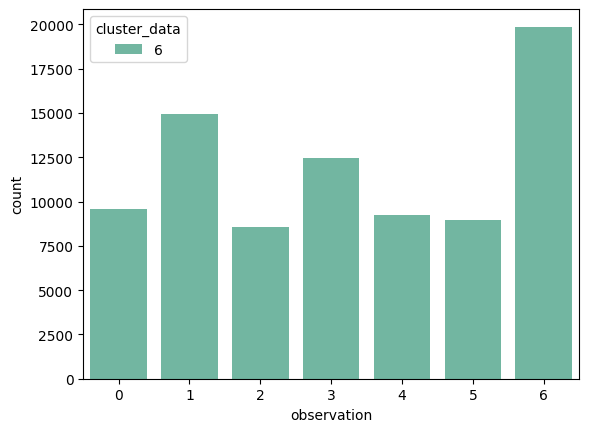

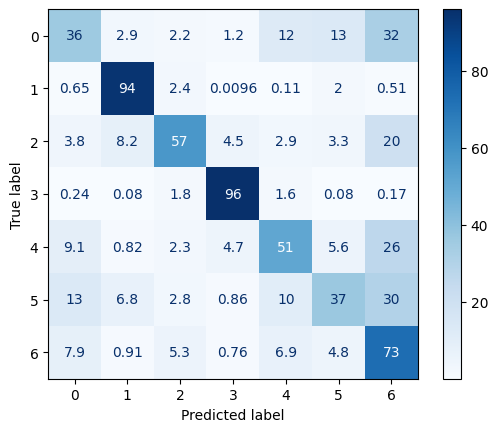

{'average_accuracy': 0.6767592149353758, 'average_f1_macro': np.float64(0.6309124452185965), 'average_f1_micro': np.float64(0.6767592149353758), 'average_auc': np.float64(0.8984711808512685), 'average_acc_kelas_generatif': 0.9590137613691637, 'average_acc_fase_padi': 0.7811880831847877}
{'val_accuracy': 0.6814778089311359, 'val_f1_macro': np.float64(0.6397135684824099), 'val_f1_micro': np.float64(0.6814778089311359), 'val_auc': np.float64(0.9031952662580585), 'val_acc_kelas_generatif': 0.960280105613592, 'val_acc_fase_padi': 0.789560213727908, 'val_relative_acc': np.float64(97.37354396042764)}
CLUSTER:  7


[I 2024-10-24 11:25:25,369] A new study created in memory with name: no-name-4e516131-5416-42ce-b082-2ef2edaede0e


[6 2 1 5 3 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 11:25:49,549] Trial 0 finished with value: 0.7399651093320107 and parameters: {'max_depth': 7, 'learning_rate': 0.08170815465270335, 'reg_lambda': 4.408640348671802, 'min_child_weight': 60}. Best is trial 0 with value: 0.7399651093320107.


[I 2024-10-24 11:26:59,193] Trial 1 finished with value: 0.7368077116461788 and parameters: {'max_depth': 7, 'learning_rate': 0.01231314703520255, 'reg_lambda': 1.8670407075601596, 'min_child_weight': 83}. Best is trial 0 with value: 0.7399651093320107.


[I 2024-10-24 11:27:31,510] Trial 2 finished with value: 0.741232100367434 and parameters: {'max_depth': 8, 'learning_rate': 0.060324517833861196, 'reg_lambda': 0.9722279354400408, 'min_child_weight': 83}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:28:40,949] Trial 3 finished with value: 0.7408908404704251 and parameters: {'max_depth': 7, 'learning_rate': 0.020721909969220687, 'reg_lambda': 1.6962042729245312, 'min_child_weight': 74}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:29:27,889] Trial 4 finished with value: 0.7399869171225012 and parameters: {'max_depth': 9, 'learning_rate': 0.03825471565782581, 'reg_lambda': 2.3569938540049913, 'min_child_weight': 84}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:29:53,579] Trial 5 finished with value: 0.7398528621693213 and parameters: {'max_depth': 8, 'learning_rate': 0.0818519056202938, 'reg_lambda': 4.095966995977946, 'min_child_weight': 95}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:30:27,987] Trial 6 finished with value: 0.7402665896881774 and parameters: {'max_depth': 10, 'learning_rate': 0.058387483264110585, 'reg_lambda': 4.230931566978853, 'min_child_weight': 64}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:30:52,105] Trial 7 finished with value: 0.7391944551895971 and parameters: {'max_depth': 7, 'learning_rate': 0.09045637973431188, 'reg_lambda': 0.8773260109780238, 'min_child_weight': 91}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:32:23,785] Trial 8 finished with value: 0.7390921945557346 and parameters: {'max_depth': 10, 'learning_rate': 0.018032246366307784, 'reg_lambda': 1.6487794848793278, 'min_child_weight': 53}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:32:56,827] Trial 9 finished with value: 0.7394642761525784 and parameters: {'max_depth': 6, 'learning_rate': 0.061855415795797175, 'reg_lambda': 2.7510715240074886, 'min_child_weight': 65}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:33:41,802] Trial 10 finished with value: 0.7392136692643184 and parameters: {'max_depth': 9, 'learning_rate': 0.0415134712413822, 'reg_lambda': 0.27770890071456356, 'min_child_weight': 76}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:34:33,884] Trial 11 finished with value: 0.7396771315980447 and parameters: {'max_depth': 8, 'learning_rate': 0.03541954187805079, 'reg_lambda': 1.1430384288494326, 'min_child_weight': 75}. Best is trial 2 with value: 0.741232100367434.


[I 2024-10-24 11:35:06,018] Trial 12 finished with value: 0.7424238801987827 and parameters: {'max_depth': 6, 'learning_rate': 0.06915041572797007, 'reg_lambda': 3.0303014185349597, 'min_child_weight': 83}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:35:37,305] Trial 13 finished with value: 0.7389729107407502 and parameters: {'max_depth': 6, 'learning_rate': 0.07001051769386137, 'reg_lambda': 3.320558942419498, 'min_child_weight': 100}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:36:09,289] Trial 14 finished with value: 0.7418035642366224 and parameters: {'max_depth': 6, 'learning_rate': 0.07055177766539308, 'reg_lambda': 3.360080870979256, 'min_child_weight': 85}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:36:38,428] Trial 15 finished with value: 0.7393765854203157 and parameters: {'max_depth': 6, 'learning_rate': 0.0734317968921536, 'reg_lambda': 3.4516315002562132, 'min_child_weight': 90}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:37:02,875] Trial 16 finished with value: 0.741152417030654 and parameters: {'max_depth': 6, 'learning_rate': 0.09522192799500817, 'reg_lambda': 3.4338016885923666, 'min_child_weight': 87}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:37:45,304] Trial 17 finished with value: 0.7415488754125987 and parameters: {'max_depth': 6, 'learning_rate': 0.04793916496831141, 'reg_lambda': 4.919183434106977, 'min_child_weight': 79}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:38:11,655] Trial 18 finished with value: 0.7406310745120829 and parameters: {'max_depth': 7, 'learning_rate': 0.07167550838612918, 'reg_lambda': 2.877418907476055, 'min_child_weight': 70}. Best is trial 12 with value: 0.7424238801987827.


[I 2024-10-24 11:38:53,418] Trial 19 finished with value: 0.7400582430122089 and parameters: {'max_depth': 6, 'learning_rate': 0.051182546689382546, 'reg_lambda': 2.249378788907934, 'min_child_weight': 97}. Best is trial 12 with value: 0.7424238801987827.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.06915041572797007, 'reg_lambda': 3.0303014185349597, 'min_child_weight': 83}
Best Score: 0.7424238801987827
Start the modelling
[0]	train-mlogloss:1.82855	eval-mlogloss:1.82349


[100]	train-mlogloss:0.49770	eval-mlogloss:0.58806


[200]	train-mlogloss:0.36614	eval-mlogloss:0.54721


[300]	train-mlogloss:0.27570	eval-mlogloss:0.53111


[400]	train-mlogloss:0.21636	eval-mlogloss:0.52487


[500]	train-mlogloss:0.17188	eval-mlogloss:0.52269


[600]	train-mlogloss:0.13749	eval-mlogloss:0.52356


[700]	train-mlogloss:0.11268	eval-mlogloss:0.52609


[800]	train-mlogloss:0.09359	eval-mlogloss:0.52983


[900]	train-mlogloss:0.07856	eval-mlogloss:0.53468


[1000]	train-mlogloss:0.06753	eval-mlogloss:0.53978


[1100]	train-mlogloss:0.05835	eval-mlogloss:0.54478


[1200]	train-mlogloss:0.05101	eval-mlogloss:0.55020


[1300]	train-mlogloss:0.04532	eval-mlogloss:0.55491


[1400]	train-mlogloss:0.04063	eval-mlogloss:0.55940


[1500]	train-mlogloss:0.03625	eval-mlogloss:0.56451


[1525]	train-mlogloss:0.03515	eval-mlogloss:0.56602


[0]	train-mlogloss:1.82828	eval-mlogloss:1.82316


[100]	train-mlogloss:0.49742	eval-mlogloss:0.58999


[200]	train-mlogloss:0.36898	eval-mlogloss:0.55022


[300]	train-mlogloss:0.28170	eval-mlogloss:0.53587


[400]	train-mlogloss:0.22035	eval-mlogloss:0.53023


[500]	train-mlogloss:0.17630	eval-mlogloss:0.52931


[600]	train-mlogloss:0.14239	eval-mlogloss:0.53099


[700]	train-mlogloss:0.11670	eval-mlogloss:0.53451


[800]	train-mlogloss:0.09746	eval-mlogloss:0.53875


[900]	train-mlogloss:0.08160	eval-mlogloss:0.54358


[1000]	train-mlogloss:0.06992	eval-mlogloss:0.54889


[1100]	train-mlogloss:0.05989	eval-mlogloss:0.55547


[1200]	train-mlogloss:0.05240	eval-mlogloss:0.56125


[1300]	train-mlogloss:0.04651	eval-mlogloss:0.56717


[1400]	train-mlogloss:0.04139	eval-mlogloss:0.57293


[1500]	train-mlogloss:0.03736	eval-mlogloss:0.57826


[1532]	train-mlogloss:0.03619	eval-mlogloss:0.57973


[0]	train-mlogloss:1.82939	eval-mlogloss:1.82233


[100]	train-mlogloss:0.50701	eval-mlogloss:0.58874


[200]	train-mlogloss:0.37576	eval-mlogloss:0.54774


[300]	train-mlogloss:0.28526	eval-mlogloss:0.53315


[400]	train-mlogloss:0.22180	eval-mlogloss:0.52726


[500]	train-mlogloss:0.17423	eval-mlogloss:0.52552


[600]	train-mlogloss:0.13896	eval-mlogloss:0.52755


[700]	train-mlogloss:0.11348	eval-mlogloss:0.53152


[800]	train-mlogloss:0.09386	eval-mlogloss:0.53524


[900]	train-mlogloss:0.07945	eval-mlogloss:0.54063


[1000]	train-mlogloss:0.06787	eval-mlogloss:0.54570


[1100]	train-mlogloss:0.05914	eval-mlogloss:0.55174


[1200]	train-mlogloss:0.05182	eval-mlogloss:0.55775


[1300]	train-mlogloss:0.04550	eval-mlogloss:0.56351


[1400]	train-mlogloss:0.04069	eval-mlogloss:0.56911


[1464]	train-mlogloss:0.03807	eval-mlogloss:0.57239


[0]	train-mlogloss:1.82910	eval-mlogloss:1.82231


[50]	train-mlogloss:0.67031	eval-mlogloss:0.67034


[100]	train-mlogloss:0.53202	eval-mlogloss:0.57905


[150]	train-mlogloss:0.46405	eval-mlogloss:0.55166


[200]	train-mlogloss:0.41146	eval-mlogloss:0.53678


[250]	train-mlogloss:0.36723	eval-mlogloss:0.52672


[300]	train-mlogloss:0.32640	eval-mlogloss:0.51954


[350]	train-mlogloss:0.29365	eval-mlogloss:0.51464


[400]	train-mlogloss:0.26581	eval-mlogloss:0.51128


[450]	train-mlogloss:0.23979	eval-mlogloss:0.50835


[500]	train-mlogloss:0.21742	eval-mlogloss:0.50642


[550]	train-mlogloss:0.19753	eval-mlogloss:0.50539


[600]	train-mlogloss:0.18155	eval-mlogloss:0.50538


[626]	train-mlogloss:0.17315	eval-mlogloss:0.50540



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40      6669
           1       0.89      0.93      0.91     12775
           2       0.92      0.95      0.94     12894
           3       0.94      0.95      0.94     12981
           4       0.88      0.95      0.91     11359
           5       0.47      0.34      0.39      6658
           6       0.72      0.81      0.76     13891

    accuracy                           0.81     77227
   macro avg       0.76      0.75      0.75     77227
weighted avg       0.80      0.81      0.80     77227



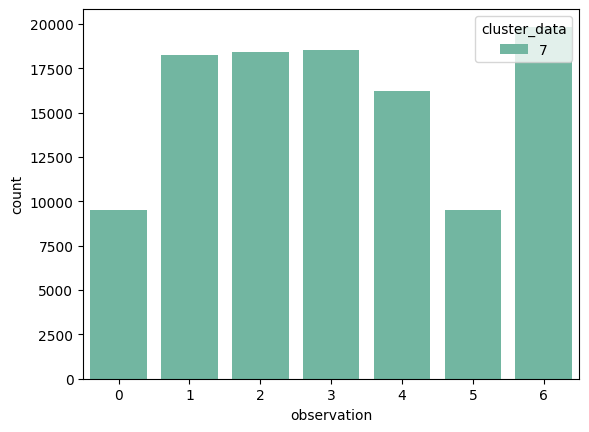

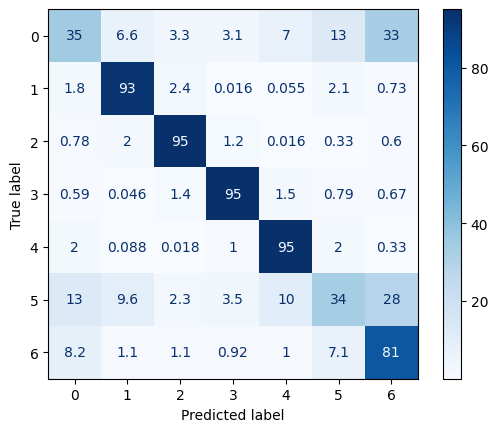

{'average_accuracy': 0.8107985714993372, 'average_f1_macro': np.float64(0.7390735034780517), 'average_f1_micro': np.float64(0.8107985714993372), 'average_auc': np.float64(0.9486513949318346), 'average_acc_kelas_generatif': 0.9484107114991893, 'average_acc_fase_padi': 0.9430291342029787}
{'val_accuracy': 0.8148833957035752, 'val_f1_macro': np.float64(0.7499586833490197), 'val_f1_micro': np.float64(0.8148833957035752), 'val_auc': np.float64(0.9520778072438251), 'val_acc_kelas_generatif': 0.9497727447808335, 'val_acc_fase_padi': 0.9436301465736168, 'val_relative_acc': np.float64(98.94168914712596)}
CLUSTER:  8


[I 2024-10-24 11:40:38,305] A new study created in memory with name: no-name-a9f9ecdc-d0a9-467f-b934-9ea2264c1397


[2 1 6 3 5 4 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-24 11:41:02,546] Trial 0 finished with value: 0.8274313512871135 and parameters: {'max_depth': 7, 'learning_rate': 0.07208075480186223, 'reg_lambda': 1.0229740287225524, 'min_child_weight': 99}. Best is trial 0 with value: 0.8274313512871135.


[I 2024-10-24 11:41:55,621] Trial 1 finished with value: 0.824668188804452 and parameters: {'max_depth': 6, 'learning_rate': 0.019629119084489163, 'reg_lambda': 4.668441050847456, 'min_child_weight': 70}. Best is trial 0 with value: 0.8274313512871135.


[I 2024-10-24 11:42:25,490] Trial 2 finished with value: 0.829494818977604 and parameters: {'max_depth': 9, 'learning_rate': 0.056578537914736944, 'reg_lambda': 4.3346282092337045, 'min_child_weight': 76}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:43:17,865] Trial 3 finished with value: 0.8278373287475399 and parameters: {'max_depth': 8, 'learning_rate': 0.028518209605588887, 'reg_lambda': 2.1861940124710046, 'min_child_weight': 64}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:43:53,354] Trial 4 finished with value: 0.8289231859855101 and parameters: {'max_depth': 8, 'learning_rate': 0.048219711533465985, 'reg_lambda': 2.2414508180882833, 'min_child_weight': 97}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:44:54,754] Trial 5 finished with value: 0.8265901622943502 and parameters: {'max_depth': 7, 'learning_rate': 0.02486450081380738, 'reg_lambda': 4.598405021748216, 'min_child_weight': 64}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:45:21,342] Trial 6 finished with value: 0.8290010804453786 and parameters: {'max_depth': 10, 'learning_rate': 0.0614066236169351, 'reg_lambda': 1.697633795637429, 'min_child_weight': 60}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:45:39,874] Trial 7 finished with value: 0.8290799373395726 and parameters: {'max_depth': 10, 'learning_rate': 0.09238180398456786, 'reg_lambda': 2.415771219460753, 'min_child_weight': 54}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:46:13,748] Trial 8 finished with value: 0.8290270564284864 and parameters: {'max_depth': 8, 'learning_rate': 0.047667253600668626, 'reg_lambda': 3.4308373153924983, 'min_child_weight': 83}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:47:13,704] Trial 9 finished with value: 0.8289402870772052 and parameters: {'max_depth': 10, 'learning_rate': 0.025717186947306042, 'reg_lambda': 0.9540386563947868, 'min_child_weight': 98}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:47:34,206] Trial 10 finished with value: 0.8280569028478552 and parameters: {'max_depth': 9, 'learning_rate': 0.0851190511058006, 'reg_lambda': 3.5307154395111446, 'min_child_weight': 82}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:47:51,837] Trial 11 finished with value: 0.8278179355290151 and parameters: {'max_depth': 9, 'learning_rate': 0.09250732948310667, 'reg_lambda': 3.289473381356893, 'min_child_weight': 54}. Best is trial 2 with value: 0.829494818977604.


[I 2024-10-24 11:48:14,025] Trial 12 finished with value: 0.8301385869665489 and parameters: {'max_depth': 9, 'learning_rate': 0.07663411540859506, 'reg_lambda': 2.866509670947933, 'min_child_weight': 77}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:48:36,985] Trial 13 finished with value: 0.8283757012280581 and parameters: {'max_depth': 9, 'learning_rate': 0.07160435205376378, 'reg_lambda': 4.000710445970529, 'min_child_weight': 78}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:49:03,355] Trial 14 finished with value: 0.8289039986527055 and parameters: {'max_depth': 9, 'learning_rate': 0.05931890241464502, 'reg_lambda': 0.1619050356787355, 'min_child_weight': 90}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:49:25,091] Trial 15 finished with value: 0.8281408370447502 and parameters: {'max_depth': 9, 'learning_rate': 0.07278017203280682, 'reg_lambda': 3.025358616658705, 'min_child_weight': 71}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:50:05,534] Trial 16 finished with value: 0.8291954405836993 and parameters: {'max_depth': 7, 'learning_rate': 0.04010420197184087, 'reg_lambda': 4.1441502905407965, 'min_child_weight': 87}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:50:27,141] Trial 17 finished with value: 0.8293759484157951 and parameters: {'max_depth': 8, 'learning_rate': 0.07744069687916058, 'reg_lambda': 4.931961402297691, 'min_child_weight': 76}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:50:52,004] Trial 18 finished with value: 0.8297752747320214 and parameters: {'max_depth': 10, 'learning_rate': 0.06463188714941477, 'reg_lambda': 2.8855348375544057, 'min_child_weight': 70}. Best is trial 12 with value: 0.8301385869665489.


[I 2024-10-24 11:51:09,745] Trial 19 finished with value: 0.8283945894122923 and parameters: {'max_depth': 10, 'learning_rate': 0.09866998486345138, 'reg_lambda': 2.9283948792979704, 'min_child_weight': 69}. Best is trial 12 with value: 0.8301385869665489.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.07663411540859506, 'reg_lambda': 2.866509670947933, 'min_child_weight': 77}
Best Score: 0.8301385869665489
Start the modelling
[0]	train-mlogloss:1.78109	eval-mlogloss:1.79519


[100]	train-mlogloss:0.21018	eval-mlogloss:0.47522


[200]	train-mlogloss:0.11742	eval-mlogloss:0.45146


[300]	train-mlogloss:0.07478	eval-mlogloss:0.45113


[400]	train-mlogloss:0.05315	eval-mlogloss:0.45673


[500]	train-mlogloss:0.04052	eval-mlogloss:0.46367


[600]	train-mlogloss:0.03252	eval-mlogloss:0.47166


[700]	train-mlogloss:0.02690	eval-mlogloss:0.47992


[800]	train-mlogloss:0.02309	eval-mlogloss:0.48576


[900]	train-mlogloss:0.02024	eval-mlogloss:0.49184


[1000]	train-mlogloss:0.01804	eval-mlogloss:0.49739


[1100]	train-mlogloss:0.01635	eval-mlogloss:0.50230


[1200]	train-mlogloss:0.01496	eval-mlogloss:0.50718


[1266]	train-mlogloss:0.01422	eval-mlogloss:0.51025


[0]	train-mlogloss:1.78069	eval-mlogloss:1.79478


[100]	train-mlogloss:0.20673	eval-mlogloss:0.48145


[200]	train-mlogloss:0.11209	eval-mlogloss:0.45764


[300]	train-mlogloss:0.07416	eval-mlogloss:0.45906


[400]	train-mlogloss:0.05255	eval-mlogloss:0.46482


[500]	train-mlogloss:0.04012	eval-mlogloss:0.47269


[600]	train-mlogloss:0.03237	eval-mlogloss:0.48042


[700]	train-mlogloss:0.02689	eval-mlogloss:0.48768


[800]	train-mlogloss:0.02303	eval-mlogloss:0.49466


[900]	train-mlogloss:0.02017	eval-mlogloss:0.50075


[1000]	train-mlogloss:0.01796	eval-mlogloss:0.50654


[1100]	train-mlogloss:0.01614	eval-mlogloss:0.51242


[1200]	train-mlogloss:0.01476	eval-mlogloss:0.51738


[1220]	train-mlogloss:0.01449	eval-mlogloss:0.51814


[0]	train-mlogloss:1.78141	eval-mlogloss:1.79472


[100]	train-mlogloss:0.21117	eval-mlogloss:0.47318


[200]	train-mlogloss:0.11549	eval-mlogloss:0.44504


[300]	train-mlogloss:0.07308	eval-mlogloss:0.44148


[400]	train-mlogloss:0.05225	eval-mlogloss:0.44609


[500]	train-mlogloss:0.04002	eval-mlogloss:0.45256


[600]	train-mlogloss:0.03224	eval-mlogloss:0.45907


[700]	train-mlogloss:0.02690	eval-mlogloss:0.46567


[800]	train-mlogloss:0.02296	eval-mlogloss:0.47257


[900]	train-mlogloss:0.02020	eval-mlogloss:0.47826


[1000]	train-mlogloss:0.01800	eval-mlogloss:0.48403


[1100]	train-mlogloss:0.01629	eval-mlogloss:0.48907


[1200]	train-mlogloss:0.01488	eval-mlogloss:0.49359


[1292]	train-mlogloss:0.01384	eval-mlogloss:0.49794


[0]	train-mlogloss:1.77799	eval-mlogloss:1.79098


[50]	train-mlogloss:0.34927	eval-mlogloss:0.53485


[100]	train-mlogloss:0.22334	eval-mlogloss:0.45830


[150]	train-mlogloss:0.16808	eval-mlogloss:0.43776


[200]	train-mlogloss:0.13348	eval-mlogloss:0.42896


[250]	train-mlogloss:0.10790	eval-mlogloss:0.42507


[300]	train-mlogloss:0.08838	eval-mlogloss:0.42381


[350]	train-mlogloss:0.07305	eval-mlogloss:0.42375


[383]	train-mlogloss:0.06618	eval-mlogloss:0.42453



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12626
           1       0.92      0.96      0.94      6858
           2       0.76      0.74      0.75      6525
           3       0.94      0.96      0.95      6842
           4       0.95      0.98      0.96      8856
           5       0.66      0.58      0.62      6642
           6       0.78      0.77      0.77     13879

    accuracy                           0.85     62228
   macro avg       0.84      0.84      0.84     62228
weighted avg       0.84      0.85      0.84     62228



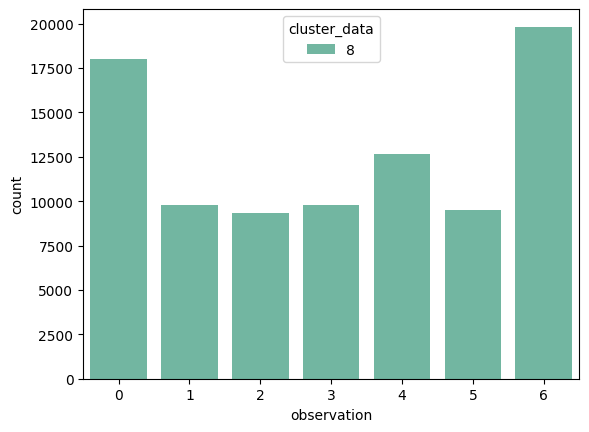

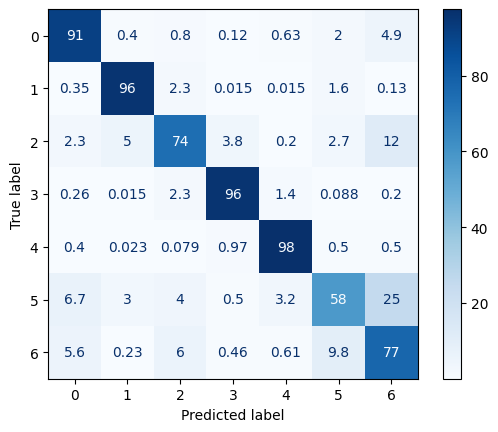

{'average_accuracy': 0.8377830344612255, 'average_f1_macro': np.float64(0.8298048488833322), 'average_f1_micro': np.float64(0.8377830344612255), 'average_auc': np.float64(0.9722331340332265), 'average_acc_kelas_generatif': 0.9539556353736485, 'average_acc_fase_padi': 0.9013079086536187}
{'val_accuracy': 0.8462428488783185, 'val_f1_macro': np.float64(0.8407690838154144), 'val_f1_micro': np.float64(0.8462428488783185), 'val_auc': np.float64(0.9753095440178713), 'val_acc_kelas_generatif': 0.9577608886290558, 'val_acc_fase_padi': 0.9144802448333964, 'val_relative_acc': np.float64(98.43068607579387)}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)